## Import libraries

In [1]:
# !pip install optuna
# !pip install catboost
# !pip install shap
# !pip install hrv-analysis
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
import warnings
import optuna
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer, auc, roc_curve
from catboost import CatBoostClassifier, Pool
import shap
from sklearn.metrics import f1_score
from hrvanalysis import remove_outliers, remove_ectopic_beats, interpolate_nan_values
warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
import streamlit as st
st.__version__

'0.79.0'

- `train.csv` обучающая выборка со следующими столбцами:  
   - **id** - идентификатор временного ряда сердечного ритма
   - **time** - время в ms ( миллисекунды)
   - **x** - R-R интервал
   - **y** - признак разметки ковидной аномалии

In [13]:
df = pd.read_csv('../data/train.csv')

In [14]:
# Train - Val - Test split
df.sort_values(by=['id', 'time'], inplace=True)

df_train = df[df.id<175].copy()
df_val = df[(df.id>=175) & (df.id<225)]
df_test = df[df.id>=225].copy()
df_train.shape, df_val.shape, df_test.shape

((43306, 4), (8872, 4), (8309, 4))

## Feature engeneering

In [5]:
# Обнаружение аномалий, накопительное среднее
def anomaly_detected(df):
  new_df = pd.DataFrame()
  for i in df.id.unique():
    new_df_tmp = pd.concat([df[df.id==i].merge(
        pd.DataFrame(remove_outliers(df[df.id==i]['x'], verbose = False), columns=['anomaly_1']),
                    on = np.arange(len(df[df.id==i]))).drop(['key_0'], axis=1)])
    new_df = pd.concat([new_df, new_df_tmp])
  new_df2 = pd.DataFrame()
  for i in df.id.unique():
    new_df2_tmp = pd.concat([df[df.id==i].merge(
        pd.DataFrame(remove_ectopic_beats(list(df[df.id==i]['x']), verbose = False), columns=['anomaly_2']),
                    on = np.arange(len(df[df.id==i]))).drop(['key_0'], axis=1)])
    new_df2 = pd.concat([new_df2, new_df2_tmp])
  new_df['anomaly__1'] = (new_df['anomaly_1'].isnull()).astype(int)
  new_df2['anomaly__2'] = (new_df2['anomaly_2'].isnull()).astype(int)
  new_df.drop(['anomaly_1'], axis=1, inplace=True)
  new_df2.drop(['anomaly_2'], axis=1, inplace=True)
  df = new_df.merge(new_df2[['id', 'time', 'anomaly__2']], on = ['id', 'time'])
  df['EMA'] = df['x'].ewm(span=40,adjust=False).mean()
  df['one'] = 1
  df['x_cummean'] = df['x'].cumsum() / df['one'].cumsum()
  df['is_anomaly'] = df['anomaly__1'] + df['anomaly__2']
  df.drop(['one'], axis=1, inplace=True)
  return df

In [6]:
df_train = anomaly_detected(df_train)
df_val = anomaly_detected(df_val)
df_test = anomaly_detected(df_test)
print(df_train.shape)

(43306, 9)


In [7]:
# Накопительное среднее без аномалий, фичи по количеству аномалий
def first_prepr(df_train, delete_anomaly = True):
    df_train.sort_values(by=['id', 'time'], inplace=True)
    df_train['anomaly1_cumsum'] = df_train.groupby(['id'])['anomaly__1'].cumsum()
    df_train['anomaly2_cumsum'] = df_train.groupby(['id'])['anomaly__2'].cumsum()
    df_train['one'] = 1
    # Номер итерации
    df_train['num_iter'] = df.groupby(['id']).cumcount()+1
    df_train = df_train.merge(df_train.groupby(['id'])['x'].mean().to_frame('mean_value'),
                                                      left_on = ['id'], right_index=True)\
        .merge(df_train.groupby(['id'])['x'].std().to_frame('std_value'), left_on = ['id'], right_index=True)\
            .merge(df_train.groupby(['id'])['x'].min().to_frame('min_value'), left_on = ['id'], right_index=True)\
                    .merge(df_train.groupby(['id'])['x'].max().to_frame('max_value'), left_on = ['id'], right_index=True)\
              .merge(df_train[df_train.is_anomaly==0].groupby(['id'])['x'].mean().to_frame('mean_not_anomaly'), 
                     left_on=['id'], right_index=True, how='left').\
              merge(df_train[df_train.is_anomaly==0].groupby(['id'])['x'].cumsum().to_frame('cumsum_wo_anomaly'), 
                     left_index =True, right_index=True, how='left').\
              merge(df_train[df_train.is_anomaly==0].groupby(['id'])['one'].cumsum().to_frame('cumcount_wo_anomaly'), 
                     left_index =True, right_index=True, how='left')
    df_train['cummean_wo_anomaly'] = df_train['cumsum_wo_anomaly'] / df_train['cumcount_wo_anomaly']
    for i in range(100):
      if df_train.cummean_wo_anomaly.isnull().sum()>0:
        df_train['cummean_wo_anomaly_sh_1'] = df_train['cummean_wo_anomaly'].shift(1)
        df_train.loc[df_train.cummean_wo_anomaly.isnull(), 'cummean_wo_anomaly'] = \
              df_train.loc[df_train.cummean_wo_anomaly.isnull(), 'cummean_wo_anomaly_sh_1']
    df_train['cummean_diff'] = df_train['cummean_wo_anomaly'] / df_train['x_cummean']
    df_train['not_anomaly_perc'] = df_train['cumcount_wo_anomaly'] / df_train['num_iter']
    df_train.drop(['cummean_wo_anomaly_sh_1', 'one', 'cumcount_wo_anomaly'], axis=1, inplace=True)
    
    if delete_anomaly:
      df_train = df_train[df_train.anomaly__1==0]
    return df_train

In [8]:
df_train = first_prepr(df_train)
df_val = first_prepr(df_val)
df_test = first_prepr(df_test)

In [9]:
# Куча фичей
def feature_generate(df_train):
    for n in tqdm_notebook([1,2,3,5,10,25,50,100,250,500, 10000]):
        df_train = df_train.merge(df_train.groupby(['id'])['x'].rolling(window=n).mean().to_frame(f'mean_rolling_{n}'),
               on = np.arange(len(df_train)), how='left').drop(['key_0'], axis=1)
        df_train = df_train.merge(df_train.groupby(['id'])['x'].rolling(window=n).std().to_frame(f'std_rolling_{n}'),
               on = np.arange(len(df_train)), how='left').drop(['key_0'], axis=1)
        df_train = df_train.merge(df_train.groupby(['id'])['x'].rolling(
            window=n, min_periods=1, center=True).mean().to_frame(f'mean_rolling_{n}_c'),
               on = np.arange(len(df_train)), how='left').drop(['key_0'], axis=1)
        df_train = df_train.merge(df_train.groupby(['id'])['x'].rolling(
            window=n, min_periods=1, center=True).std().to_frame(f'std_rolling_{n}_c'),
               on = np.arange(len(df_train)), how='left').drop(['key_0'], axis=1)
        df_train = df_train.merge(df_train.groupby(['id'])['x'].rolling(window=n, min_periods=1)\
            .max().to_frame(f'max_rolling_1_{n}'),on = np.arange(len(df_train)), how='left').drop(['key_0'], axis=1)
        df_train[f'max_rolling_1_{n}_rel1'] = df_train[f'max_rolling_1_{n}'] / df_train[f'mean_value']
        df_train[f'max_rolling_1_{n}_rel2'] = df_train[f'max_rolling_1_{n}'] / df_train[f'max_value']
        df_train[f'max_rolling_1_{n}_rel3'] = df_train[f'max_rolling_1_{n}'] / df_train[f'min_value']
        df_train[f'max_rolling_1_{n}_rel4'] = df_train[f'max_rolling_1_{n}'] / df_train[f'cummean_wo_anomaly']
        df_train[f'max_rolling_1_{n}_rel5'] = df_train[f'max_rolling_1_{n}'] / df_train[f'EMA']
        df_train = df_train.merge(df_train.groupby(['id'])['x'].rolling(window=n, min_periods=1)\
            .mean().to_frame(f'mean_rolling_1_{n}'),on = np.arange(len(df_train)), how='left').drop(['key_0'], axis=1)
        df_train = df_train.merge(df_train.groupby(['id'])['anomaly__1'].rolling(window=n, min_periods=1)\
            .mean().to_frame(f'mean_rolling_new_{n}'),on = np.arange(len(df_train)), how='left').drop(['key_0'], axis=1)
        df_train = df_train.merge(df_train.groupby(['id'])['anomaly__2'].rolling(window=n, min_periods=1)\
            .mean().to_frame(f'mean_rolling_new2_{n}'),on = np.arange(len(df_train)), how='left').drop(['key_0'], axis=1)
        df_train[f'mean_rolling_1_{n}_rel1'] = df_train[f'mean_rolling_1_{n}'] / df_train[f'mean_value']
        df_train[f'mean_rolling_1_{n}_rel2'] = df_train[f'mean_rolling_1_{n}'] / df_train[f'max_value']
        df_train[f'mean_rolling_1_{n}_rel3'] = df_train[f'mean_rolling_1_{n}'] / df_train[f'min_value']
        df_train[f'mean_rolling_1_{n}_rel4'] = df_train[f'mean_rolling_1_{n}'] / df_train[f'cummean_wo_anomaly']
        df_train[f'mean_rolling_1_{n}_rel5'] = df_train[f'mean_rolling_1_{n}'] / df_train[f'EMA']
       
        df_train = df_train.merge(df_train.groupby(['id'])['x'].rolling(window=n, min_periods=1)\
            .min().to_frame(f'min_rolling_1_{n}'),on = np.arange(len(df_train)), how='left').drop(['key_0'], axis=1)
        df_train[f'min_rolling_1_{n}_rel1'] = df_train[f'min_rolling_1_{n}'] / df_train[f'mean_value']
        df_train[f'min_rolling_1_{n}_rel2'] = df_train[f'min_rolling_1_{n}'] / df_train[f'max_value']
        df_train[f'min_rolling_1_{n}_rel3'] = df_train[f'min_rolling_1_{n}'] / df_train[f'min_value']
        df_train[f'min_rolling_1_{n}_rel4'] = df_train[f'min_rolling_1_{n}'] / df_train[f'cummean_wo_anomaly']
        df_train[f'min_rolling_1_{n}_rel5'] = df_train[f'min_rolling_1_{n}'] / df_train[f'EMA']
        df_train = df_train.merge(df_train.groupby(['id'])['x'].rolling(window=n, min_periods=1)\
            .median().to_frame(f'median_rolling_1_{n}'),on = np.arange(len(df_train)), how='left').drop(['key_0'], axis=1)
        df_train[f'median_rolling_1_{n}_rel1'] = df_train[f'median_rolling_1_{n}'] / df_train[f'mean_value']
        df_train[f'median_rolling_1_{n}_rel2'] = df_train[f'median_rolling_1_{n}'] / df_train[f'max_value']
        df_train[f'median_rolling_1_{n}_rel3'] = df_train[f'median_rolling_1_{n}'] / df_train[f'min_value']
        df_train[f'median_rolling_1_{n}_rel4'] = df_train[f'median_rolling_1_{n}'] / df_train[f'cummean_wo_anomaly']
        df_train[f'median_rolling_1_{n}_rel5'] = df_train[f'median_rolling_1_{n}'] / df_train[f'EMA']
        df_train = df_train.merge(df_train.groupby(['id'])['x'].rolling(window=n, min_periods=1)\
            .std().to_frame(f'std_rolling_1_{n}'),on = np.arange(len(df_train)), how='left').drop(['key_0'], axis=1)        
        df_train[f'std_rolling_1_{n}_rel1'] = df_train[f'std_rolling_1_{n}'] / df_train[f'std_value']
        df_train[f'std_rolling_1_{n}_rel2'] = df_train[f'std_rolling_1_{n}'] / df_train[f'mean_value']
        df_train[f'std_rolling_1_{n}_rel3'] = df_train[f'std_rolling_1_{n}'] / df_train[f'cummean_wo_anomaly']
        df_train[f'std_rolling_1_{n}_rel4'] = df_train[f'std_rolling_1_{n}'] / df_train[f'EMA']

        df_train[f'up_anomaly_{n}'] = (df_train['x'] > df_train[f'mean_rolling_1_{n}_rel3'] + \
                                        df_train[f'std_rolling_1_{n}']).astype(int)
        df_train[f'up_anomaly2_{n}'] = (df_train['x'] > df_train[f'mean_rolling_1_{n}_rel3'] + \
                                        2* df_train[f'std_rolling_1_{n}']).astype(int)
        df_train[f'up_anomaly3_{n}'] = (df_train['x'] > df_train[f'mean_rolling_1_{n}_rel3'] + \
                                        3 * df_train[f'std_rolling_1_{n}']).astype(int)
        df_train[f'down_anomaly_{n}'] = (df_train['x'] < df_train[f'mean_rolling_1_{n}_rel3'] - \
                                        df_train[f'std_rolling_1_{n}']).astype(int)
        df_train[f'down_anomaly2_{n}'] = (df_train['x'] < df_train[f'mean_rolling_1_{n}_rel3'] - \
                                        2*df_train[f'std_rolling_1_{n}']).astype(int)
        df_train[f'down_anomaly3_{n}'] = (df_train['x'] < df_train[f'mean_rolling_1_{n}_rel3'] - \
                                       3* df_train[f'std_rolling_1_{n}']).astype(int)
        df_train[f'is_anomaly_{n}'] = df_train[f'up_anomaly_{n}'] + df_train[f'up_anomaly2_{n}'] + \
          df_train[f'up_anomaly3_{n}'] + df_train[f'down_anomaly_{n}'] + df_train[f'down_anomaly2_{n}'] + \
            df_train[f'down_anomaly3_{n}']

        df_train[f'4up_anomaly_{n}'] = (df_train['x'] > df_train[f'mean_rolling_1_{n}_rel4'] + \
                                        df_train[f'std_rolling_1_{n}']).astype(int)
        df_train[f'4up_anomaly2_{n}'] = (df_train['x'] > df_train[f'mean_rolling_1_{n}_rel4'] + \
                                        2* df_train[f'std_rolling_1_{n}']).astype(int)
        df_train[f'4up_anomaly3_{n}'] = (df_train['x'] > df_train[f'mean_rolling_1_{n}_rel4'] + \
                                        3 * df_train[f'std_rolling_1_{n}']).astype(int)
        df_train[f'4down_anomaly_{n}'] = (df_train['x'] < df_train[f'mean_rolling_1_{n}_rel4'] - \
                                        df_train[f'std_rolling_1_{n}']).astype(int)
        df_train[f'4down_anomaly2_{n}'] = (df_train['x'] < df_train[f'mean_rolling_1_{n}_rel4'] - \
                                        2*df_train[f'std_rolling_1_{n}']).astype(int)
        df_train[f'4down_anomaly3_{n}'] = (df_train['x'] < df_train[f'mean_rolling_1_{n}_rel4'] - \
                                       3* df_train[f'std_rolling_1_{n}']).astype(int)
        df_train[f'4is_anomaly_{n}'] = df_train[f'4up_anomaly_{n}'] + df_train[f'4up_anomaly2_{n}'] + \
          df_train[f'4up_anomaly3_{n}'] + df_train[f'4down_anomaly_{n}'] + df_train[f'4down_anomaly2_{n}'] + \
            df_train[f'4down_anomaly3_{n}']        
    df_train['strange_x1'] = df_train['x'] / df_train[f'mean_value']
    df_train['strange_x2'] = df_train['x'] / df_train[f'cummean_wo_anomaly']
    df_train['strange_x3'] = df_train['x'] / df_train[f'x_cummean']
    df_train['strange_x4'] = df_train['x'] / df_train[f'EMA']
    df_train['strange_x5'] = df_train['x'] / df_train[f'mean_rolling_5']
    df_train['strange_x6'] = df_train['x'] / df_train[f'mean_rolling_100']
    df_train.num_iter = (df_train.num_iter//100)
    df_train['less066'] = (df_train['x'] / df_train['cummean_wo_anomaly'] <0.66).astype(int)
    df_train['more133'] = (df_train['x'] / df_train['cummean_wo_anomaly'] >1.33).astype(int)
    return df_train

In [10]:
df_train = feature_generate(df_train)
df_val = feature_generate(df_val)
df_test = feature_generate(df_test)

In [23]:
df_train.groupby(['less066'])['y'].sum()

less066
0    5845
1       4
Name: y, dtype: int64

In [56]:
df_train.groupby(['mean_rolling_new2_1'])['y'].sum()

mean_rolling_new2_1
0.0    5829
1.0      16
Name: y, dtype: int64

In [59]:
df_train = df_train[df_train['mean_rolling_new2_1']==0]
df_val = df_val[df_val['mean_rolling_new2_1']==0]
df_test = df_test[df_test['mean_rolling_new2_1']==0]

In [60]:
df_train = df_train[df_train.less066==0]
df_val = df_val[df_val.less066==0]
df_test = df_test[df_test.less066==0]

In [61]:
df_train.shape, df_val.shape, df_test.shape

((33978, 568), (6878, 568), (6804, 568))

In [62]:
df_train['y'].mean()

0.1715521808228854

In [63]:
stat = pd.DataFrame()
for i in df_train.columns:
  stat = pd.concat([stat, pd.DataFrame(df_train.groupby(['y'])[i].mean()).T])

In [64]:
stat['diff'] = (stat[1] - stat[0])/stat[0]

In [65]:
stat[~stat['diff'].isnull()].sort_values(by=['diff'])

y,0,1,diff
mean_rolling_new2_2,0.035241,0.002659,-0.924545
mean_rolling_new2_3,0.045982,0.004403,-0.904238
mean_rolling_new2_5,0.055877,0.007720,-0.861839
more133,0.030445,0.006176,-0.797143
num_iter,4.898149,1.040659,-0.787540
...,...,...,...
std_rolling_1_3_rel1,0.318664,0.514529,0.614642
min_rolling_1_10000_rel2,0.329276,0.539137,0.637343
min_value,231.176809,392.107394,0.696136
std_rolling_1_2_rel1,0.249607,0.458809,0.838124


## Обучений моделей, подбор фичей и параметров

In [68]:
train_pool = Pool(df_train.drop(['id', 'y'], axis=1), df_train['y'])
val_pool = Pool(df_val.drop(['id', 'y'], axis=1), df_val['y'])
test_pool = Pool(df_test.drop(['id', 'y'], axis=1), df_test['y'])

In [69]:
y_train = df_train['y']
y_val = df_val['y']

In [70]:
def objective(trial): 
    param = {                 
            'depth' : trial.suggest_int('max_depth',1,7),
            'n_estimators':  trial.suggest_int("n_estimators", 100, 1000),
            'l2_leaf_reg': trial.suggest_uniform("reg_lambda", 0, 100),
            'learning_rate' : trial.suggest_loguniform('learning_rate',0.01,0.1),
            'border_count': trial.suggest_int("border_count", 1, 255),
            'random_strength' : trial.suggest_loguniform('random_strength', 1e-9, 10),
            'bagging_temperature': trial.suggest_uniform("bagging_temperature", 0, 1),
        'task_type': 'GPU',
        "loss_function":'Logloss', 
        'random_state':123,
        "verbose": False
    }
    
    cb = CatBoostClassifier(**param)
    cb.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50, verbose=0)
    
    train_auc = roc_auc_score(y_train, cb.predict_proba(train_pool)[:,1])
    test_auc = roc_auc_score(y_val, cb.predict_proba(val_pool)[:,1])
    print(f"TRAIN GINI = {2*train_auc-1}")
    print(f"Validate GINI = {2*test_auc-1}")
    res_val = []
    res_train = []
    res_test = []
    for i in np.linspace(0,1,50):
        res_val.append(f1_score(df_val['y'], cb.predict_proba(val_pool)[:,1]>i))
        res_train.append(f1_score(df_train['y'], cb.predict_proba(train_pool)[:,1]>i))
        res_test.append(f1_score(df_test['y'], cb.predict_proba(test_pool)[:,1]>i))
    print('f1 train = ', round(np.max(res_train), 4))
    print('f1 val = ', round(np.max(res_val), 4))
    print('f1 test = ', round(res_test[np.argmax(res_val)], 4))
    return np.max(res_val)#-train_auc + 10 * test_auc

In [71]:
study_cb = optuna.create_study(direction='maximize')
study_cb.optimize(objective, n_trials=25)

[I 2021-06-13 17:16:39,064] A new study created in memory with name: no-name-f25abe13-e342-4cd2-a0af-74f890dfc833


TRAIN GINI = 0.852203333752213
Validate GINI = 0.7545582306369676


[I 2021-06-13 17:16:54,316] Trial 0 finished with value: 0.6524245506951509 and parameters: {'max_depth': 1, 'n_estimators': 574, 'reg_lambda': 96.9340794486101, 'learning_rate': 0.07252145477286852, 'border_count': 28, 'random_strength': 0.003905880064600551, 'bagging_temperature': 0.45614900641897604}. Best is trial 0 with value: 0.6524245506951509.


f1 train =  0.7253
f1 val =  0.6524
f1 test =  0.6334
TRAIN GINI = 0.9102061907762957
Validate GINI = 0.7824003102606472


[I 2021-06-13 17:17:07,840] Trial 1 finished with value: 0.667717528373266 and parameters: {'max_depth': 3, 'n_estimators': 551, 'reg_lambda': 39.14333769161603, 'learning_rate': 0.05288632181511332, 'border_count': 38, 'random_strength': 4.007925452156242e-09, 'bagging_temperature': 0.9334593142630969}. Best is trial 1 with value: 0.667717528373266.


f1 train =  0.7781
f1 val =  0.6677
f1 test =  0.6338
TRAIN GINI = 0.9535736298643278
Validate GINI = 0.8074722767481106


[I 2021-06-13 17:17:21,706] Trial 2 finished with value: 0.6810744056807657 and parameters: {'max_depth': 5, 'n_estimators': 601, 'reg_lambda': 65.35610268419669, 'learning_rate': 0.08115774830365269, 'border_count': 20, 'random_strength': 1.20850595961552e-08, 'bagging_temperature': 0.5174917397237961}. Best is trial 2 with value: 0.6810744056807657.


f1 train =  0.838
f1 val =  0.6811
f1 test =  0.6494
TRAIN GINI = 0.8167976928839713
Validate GINI = 0.7430389816033234


[I 2021-06-13 17:17:25,844] Trial 3 finished with value: 0.6406790317510216 and parameters: {'max_depth': 1, 'n_estimators': 234, 'reg_lambda': 63.11944753366414, 'learning_rate': 0.0546767012073606, 'border_count': 163, 'random_strength': 0.18632909721231425, 'bagging_temperature': 0.834371723477215}. Best is trial 2 with value: 0.6810744056807657.


f1 train =  0.6973
f1 val =  0.6407
f1 test =  0.6034
TRAIN GINI = 0.8948887845133062
Validate GINI = 0.7750495655590741


[I 2021-06-13 17:17:46,647] Trial 4 finished with value: 0.6579785693599768 and parameters: {'max_depth': 3, 'n_estimators': 801, 'reg_lambda': 41.59194144365217, 'learning_rate': 0.03883782019068557, 'border_count': 4, 'random_strength': 2.6768554002796074, 'bagging_temperature': 0.5566582156976664}. Best is trial 2 with value: 0.6810744056807657.


f1 train =  0.7649
f1 val =  0.658
f1 test =  0.5988
TRAIN GINI = 0.874201996225987
Validate GINI = 0.7685143517358259


[I 2021-06-13 17:17:52,337] Trial 5 finished with value: 0.6664588528678305 and parameters: {'max_depth': 3, 'n_estimators': 286, 'reg_lambda': 42.41713745570772, 'learning_rate': 0.02483841579107604, 'border_count': 204, 'random_strength': 0.0010770402801149092, 'bagging_temperature': 0.3717810615149111}. Best is trial 2 with value: 0.6810744056807657.


f1 train =  0.7404
f1 val =  0.6665
f1 test =  0.6242
TRAIN GINI = 0.8134956982492758
Validate GINI = 0.7473764743019915


[I 2021-06-13 17:17:56,691] Trial 6 finished with value: 0.6355247981545559 and parameters: {'max_depth': 3, 'n_estimators': 232, 'reg_lambda': 81.94229423328852, 'learning_rate': 0.010451581911618617, 'border_count': 34, 'random_strength': 1.2036233173311917e-05, 'bagging_temperature': 0.7172910930020969}. Best is trial 2 with value: 0.6810744056807657.


f1 train =  0.6979
f1 val =  0.6355
f1 test =  0.5868
TRAIN GINI = 0.9648502944478095
Validate GINI = 0.8018078016545158


[I 2021-06-13 17:18:15,593] Trial 7 finished with value: 0.6795670711708757 and parameters: {'max_depth': 4, 'n_estimators': 908, 'reg_lambda': 56.812099872221346, 'learning_rate': 0.08596397854538632, 'border_count': 63, 'random_strength': 3.6237334903363566e-08, 'bagging_temperature': 0.02414310025127553}. Best is trial 2 with value: 0.6810744056807657.


f1 train =  0.8583
f1 val =  0.6796
f1 test =  0.652
TRAIN GINI = 0.8343050787850683
Validate GINI = 0.7620855656891803


[I 2021-06-13 17:18:20,141] Trial 8 finished with value: 0.657191201353638 and parameters: {'max_depth': 2, 'n_estimators': 258, 'reg_lambda': 60.10955917214675, 'learning_rate': 0.024212843825882072, 'border_count': 64, 'random_strength': 1.8221494424259799, 'bagging_temperature': 0.7435901432723878}. Best is trial 2 with value: 0.6810744056807657.


f1 train =  0.7041
f1 val =  0.6572
f1 test =  0.6173
TRAIN GINI = 0.8156753475935148
Validate GINI = 0.739886899924616


[I 2021-06-13 17:18:27,525] Trial 9 finished with value: 0.6461538461538462 and parameters: {'max_depth': 3, 'n_estimators': 363, 'reg_lambda': 45.59049866377916, 'learning_rate': 0.010965663001264064, 'border_count': 245, 'random_strength': 6.981538512743935, 'bagging_temperature': 0.700527332212743}. Best is trial 2 with value: 0.6810744056807657.


f1 train =  0.6879
f1 val =  0.6462
f1 test =  0.5572
TRAIN GINI = 0.9745123615252296
Validate GINI = 0.7961763515735669


[I 2021-06-13 17:18:43,988] Trial 10 finished with value: 0.6927480916030534 and parameters: {'max_depth': 7, 'n_estimators': 758, 'reg_lambda': 6.22341053991218, 'learning_rate': 0.09952486916413943, 'border_count': 117, 'random_strength': 4.21026555348816e-07, 'bagging_temperature': 0.13529183059539435}. Best is trial 10 with value: 0.6927480916030534.


f1 train =  0.8775
f1 val =  0.6927
f1 test =  0.6512
TRAIN GINI = 0.9605190917208264
Validate GINI = 0.7881241057543156


[I 2021-06-13 17:18:57,257] Trial 11 finished with value: 0.6829268292682927 and parameters: {'max_depth': 7, 'n_estimators': 739, 'reg_lambda': 2.3049414052930723, 'learning_rate': 0.09782313235980834, 'border_count': 117, 'random_strength': 3.8588015662475683e-07, 'bagging_temperature': 0.18291308447147817}. Best is trial 10 with value: 0.6927480916030534.


f1 train =  0.8502
f1 val =  0.6829
f1 test =  0.6309
TRAIN GINI = 0.963858287602585
Validate GINI = 0.7874125101988094


[I 2021-06-13 17:19:10,898] Trial 12 finished with value: 0.6775157754898704 and parameters: {'max_depth': 7, 'n_estimators': 764, 'reg_lambda': 1.658195095522518, 'learning_rate': 0.09502094062983664, 'border_count': 108, 'random_strength': 1.3994153422026372e-06, 'bagging_temperature': 0.08457443375206518}. Best is trial 10 with value: 0.6927480916030534.


f1 train =  0.8552
f1 val =  0.6775
f1 test =  0.645
TRAIN GINI = 0.9560705380744128
Validate GINI = 0.7933461703011422


[I 2021-06-13 17:19:22,991] Trial 13 finished with value: 0.6735350933676755 and parameters: {'max_depth': 7, 'n_estimators': 979, 'reg_lambda': 0.6958336009434634, 'learning_rate': 0.09823357326163273, 'border_count': 124, 'random_strength': 4.975426193833843e-07, 'bagging_temperature': 0.22087897989375793}. Best is trial 10 with value: 0.6927480916030534.


f1 train =  0.8373
f1 val =  0.6735
f1 test =  0.6306
TRAIN GINI = 0.9701704811139651
Validate GINI = 0.8116949919499974


[I 2021-06-13 17:19:47,511] Trial 14 finished with value: 0.6927487352445195 and parameters: {'max_depth': 6, 'n_estimators': 751, 'reg_lambda': 19.612987535161885, 'learning_rate': 0.05487853211035497, 'border_count': 166, 'random_strength': 2.3523347592089216e-07, 'bagging_temperature': 0.20062512977644842}. Best is trial 14 with value: 0.6927487352445195.


f1 train =  0.8695
f1 val =  0.6927
f1 test =  0.6519
TRAIN GINI = 0.9694219218136197
Validate GINI = 0.8037878069410103


[I 2021-06-13 17:20:11,504] Trial 15 finished with value: 0.6878436163714111 and parameters: {'max_depth': 6, 'n_estimators': 666, 'reg_lambda': 20.140807985798933, 'learning_rate': 0.056152413095624465, 'border_count': 192, 'random_strength': 4.26556621637732e-05, 'bagging_temperature': 0.26058657119996087}. Best is trial 14 with value: 0.6927487352445195.


f1 train =  0.8654
f1 val =  0.6878
f1 test =  0.6444
TRAIN GINI = 0.9500445820744317
Validate GINI = 0.7945060336698104


[I 2021-06-13 17:20:35,285] Trial 16 finished with value: 0.6796052631578948 and parameters: {'max_depth': 6, 'n_estimators': 883, 'reg_lambda': 19.778733108613725, 'learning_rate': 0.033296993000803625, 'border_count': 145, 'random_strength': 9.208725995014686e-08, 'bagging_temperature': 0.014095231719442464}. Best is trial 14 with value: 0.6927487352445195.


f1 train =  0.834
f1 val =  0.6796
f1 test =  0.6595
TRAIN GINI = 0.9600489506002972
Validate GINI = 0.8029854860677441


[I 2021-06-13 17:20:42,287] Trial 17 finished with value: 0.69327325394271 and parameters: {'max_depth': 6, 'n_estimators': 465, 'reg_lambda': 20.07598765666815, 'learning_rate': 0.06585044949971043, 'border_count': 92, 'random_strength': 1.1083031466607457e-05, 'bagging_temperature': 0.33348818746112613}. Best is trial 17 with value: 0.69327325394271.


f1 train =  0.8496
f1 val =  0.6933
f1 test =  0.6457
TRAIN GINI = 0.9592759520796501
Validate GINI = 0.7942197753526479


[I 2021-06-13 17:20:51,253] Trial 18 finished with value: 0.687373396353815 and parameters: {'max_depth': 5, 'n_estimators': 428, 'reg_lambda': 27.47766132097394, 'learning_rate': 0.043201600396238396, 'border_count': 84, 'random_strength': 1.0427544973378118e-09, 'bagging_temperature': 0.34912063165103213}. Best is trial 17 with value: 0.69327325394271.


f1 train =  0.8458
f1 val =  0.6874
f1 test =  0.6498
TRAIN GINI = 0.9636423814134525
Validate GINI = 0.8107767719757466


[I 2021-06-13 17:20:59,096] Trial 19 finished with value: 0.6950776346217377 and parameters: {'max_depth': 6, 'n_estimators': 449, 'reg_lambda': 28.839107410266198, 'learning_rate': 0.06483153401973087, 'border_count': 176, 'random_strength': 1.083814215203129e-05, 'bagging_temperature': 0.3166647571950393}. Best is trial 19 with value: 0.6950776346217377.


f1 train =  0.8511
f1 val =  0.6951
f1 test =  0.6415
TRAIN GINI = 0.9105824084993
Validate GINI = 0.7872473851355788


[I 2021-06-13 17:21:03,394] Trial 20 finished with value: 0.6755674232309746 and parameters: {'max_depth': 5, 'n_estimators': 100, 'reg_lambda': 30.75512410113519, 'learning_rate': 0.06674244184294588, 'border_count': 219, 'random_strength': 0.002328997712408876, 'bagging_temperature': 0.33392319790379305}. Best is trial 19 with value: 0.6950776346217377.


f1 train =  0.7738
f1 val =  0.6756
f1 test =  0.6462
TRAIN GINI = 0.9618945688257536
Validate GINI = 0.791641705780536


[I 2021-06-13 17:21:10,825] Trial 21 finished with value: 0.6876240900066182 and parameters: {'max_depth': 6, 'n_estimators': 450, 'reg_lambda': 14.639384252106886, 'learning_rate': 0.06312266050831408, 'border_count': 170, 'random_strength': 5.932897762634855e-06, 'bagging_temperature': 0.42835875358525966}. Best is trial 19 with value: 0.6950776346217377.


f1 train =  0.851
f1 val =  0.6876
f1 test =  0.645
TRAIN GINI = 0.9600246881224859
Validate GINI = 0.7880027232550051


[I 2021-06-13 17:21:19,392] Trial 22 finished with value: 0.6790821416694379 and parameters: {'max_depth': 6, 'n_estimators': 441, 'reg_lambda': 12.111131145760211, 'learning_rate': 0.042333735219197734, 'border_count': 172, 'random_strength': 0.00021491124016923628, 'bagging_temperature': 0.26394338142334073}. Best is trial 19 with value: 0.6950776346217377.


f1 train =  0.8431
f1 val =  0.6791
f1 test =  0.6431
TRAIN GINI = 0.9644343523263192
Validate GINI = 0.7952247327186024


[I 2021-06-13 17:21:30,433] Trial 23 finished with value: 0.6827361563517915 and parameters: {'max_depth': 5, 'n_estimators': 499, 'reg_lambda': 31.242877562577675, 'learning_rate': 0.047296771999674116, 'border_count': 236, 'random_strength': 3.4514027628854825e-06, 'bagging_temperature': 0.5578540754445744}. Best is trial 19 with value: 0.6950776346217377.


f1 train =  0.853
f1 val =  0.6827
f1 test =  0.6524
TRAIN GINI = 0.950643470957774
Validate GINI = 0.7980600235212862


[I 2021-06-13 17:21:39,270] Trial 24 finished with value: 0.6853097345132744 and parameters: {'max_depth': 6, 'n_estimators': 353, 'reg_lambda': 24.017886690119656, 'learning_rate': 0.03112200642835678, 'border_count': 145, 'random_strength': 7.555301130517956e-05, 'bagging_temperature': 0.1271638853728477}. Best is trial 19 with value: 0.6950776346217377.


f1 train =  0.8332
f1 val =  0.6853
f1 test =  0.6469


In [74]:
best_params = {'max_depth': 6, 'n_estimators': 449, 'reg_lambda': 28.839107410266198,
               'learning_rate': 0.06483153401973087, 'border_count': 176,
               'random_strength': 1.083814215203129e-05, 'bagging_temperature': 0.3166647571950393,
                       'task_type': 'GPU',
        "loss_function":'Logloss' ,
        'random_state':123}

In [75]:
cb = CatBoostClassifier(**best_params)
cb.fit(train_pool, eval_set=val_pool, verbose=100, early_stopping_rounds=50)

0:	learn: 0.6259635	test: 0.6354983	best: 0.6354983 (0)	total: 12.5ms	remaining: 5.6s
100:	learn: 0.1860824	test: 0.3357945	best: 0.3351386 (99)	total: 1.24s	remaining: 4.26s
200:	learn: 0.1508702	test: 0.3240915	best: 0.3235214 (195)	total: 2.47s	remaining: 3.05s
bestTest = 0.3221677629
bestIteration = 228
Shrink model to first 229 iterations.


In [76]:
res_val = []
res_train = []
res_test = []
for i in np.linspace(0,1,50):
    res_val.append(f1_score(df_val['y'], cb.predict_proba(val_pool)[:,1]>i))
    res_train.append(f1_score(df_train['y'], cb.predict_proba(train_pool)[:,1]>i))
    res_test.append(f1_score(df_test['y'], cb.predict_proba(test_pool)[:,1]>i))

In [77]:
print('f1 val = ', round(np.max(res_val), 4))
print('f1 test = ', round(res_test[np.argmax(res_val)], 4))
print(np.linspace(0,1,50)[np.argmax(res_val)])

f1 val =  0.6951
f1 test =  0.6415
0.22448979591836732


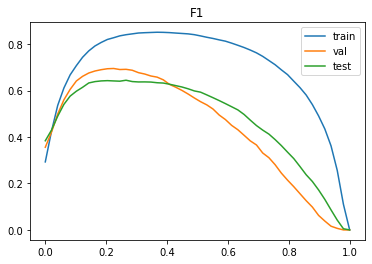

In [78]:
plt.title('F1')
plt.plot(np.linspace(0,1,50), res_train, label='train')
plt.plot(np.linspace(0,1,50), res_val, label='val')
plt.plot(np.linspace(0,1,50), res_test, label='test')
plt.legend()

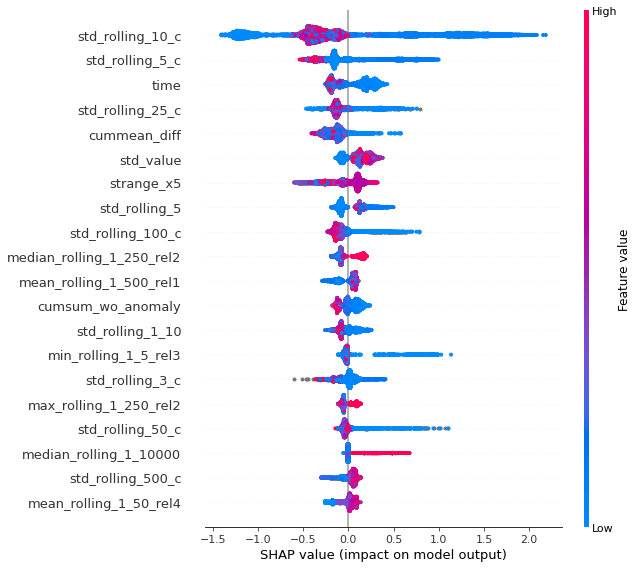

In [79]:
shap_values = cb.get_feature_importance(val_pool, type='ShapValues')[:,:-1]
shap.summary_plot(shap_values, df_val.drop(['id', 'y'], axis=1))

In [80]:
cb_imps = pd.DataFrame({'cols':df_val.drop(['id', 'y'], axis=1).columns, 
                        'imps': np.mean(np.abs(shap_values),axis=0)}).sort_values(by=['imps'], ascending=False)

In [81]:
new_cols = list(cb_imps[cb_imps.imps>0.03]['cols'])

In [82]:
len(new_cols)

34

In [83]:
new_cols

['std_rolling_10_c',
 'std_rolling_5_c',
 'time',
 'std_rolling_25_c',
 'cummean_diff',
 'std_value',
 'strange_x5',
 'std_rolling_5',
 'std_rolling_100_c',
 'median_rolling_1_250_rel2',
 'mean_rolling_1_500_rel1',
 'cumsum_wo_anomaly',
 'std_rolling_1_10',
 'min_rolling_1_5_rel3',
 'std_rolling_3_c',
 'max_rolling_1_250_rel2',
 'std_rolling_50_c',
 'median_rolling_1_10000',
 'std_rolling_500_c',
 'mean_rolling_1_50_rel4',
 'std_rolling_1_25',
 'num_iter',
 'std_rolling_1_10_rel4',
 'min_rolling_1_10000',
 'min_rolling_1_10000_rel1',
 'std_rolling_1_10000_rel1',
 'max_rolling_1_10000_rel4',
 'std_rolling_1_25_rel4',
 'max_value',
 'x_cummean',
 'std_rolling_1_2_rel4',
 'std_rolling_1_5_rel1',
 'median_rolling_1_25_rel4',
 'median_rolling_1_10000_rel4']

In [84]:
train_pool = Pool(df_train[new_cols], df_train['y'])
val_pool = Pool(df_val[new_cols], df_val['y'])
test_pool = Pool(df_test[new_cols], df_test['y'])

In [85]:
study_cb = optuna.create_study(direction='maximize')
study_cb.optimize(objective, n_trials=50)

[I 2021-06-13 17:22:54,327] A new study created in memory with name: no-name-03e4149a-514e-4188-872c-df51e9fee610


TRAIN GINI = 0.7557710948516554
Validate GINI = 0.6632870654983205


[I 2021-06-13 17:22:56,857] Trial 0 finished with value: 0.6083858591394902 and parameters: {'max_depth': 1, 'n_estimators': 158, 'reg_lambda': 61.71221042219731, 'learning_rate': 0.017822984871203106, 'border_count': 226, 'random_strength': 0.0047758463385913046, 'bagging_temperature': 0.7680849457836763}. Best is trial 0 with value: 0.6083858591394902.


f1 train =  0.6447
f1 val =  0.6084
f1 test =  0.5413
TRAIN GINI = 0.7845093629365061
Validate GINI = 0.700926233213168


[I 2021-06-13 17:23:01,558] Trial 1 finished with value: 0.6054846592451805 and parameters: {'max_depth': 1, 'n_estimators': 490, 'reg_lambda': 81.43912105161614, 'learning_rate': 0.010543236051250213, 'border_count': 218, 'random_strength': 6.5164147861730785e-06, 'bagging_temperature': 0.059795455890440996}. Best is trial 0 with value: 0.6083858591394902.


f1 train =  0.6657
f1 val =  0.6055
f1 test =  0.5579
TRAIN GINI = 0.8806147318364499
Validate GINI = 0.7309659093387384


[I 2021-06-13 17:23:04,746] Trial 2 finished with value: 0.6339082329970712 and parameters: {'max_depth': 2, 'n_estimators': 315, 'reg_lambda': 1.4580575368196347, 'learning_rate': 0.09759312985584456, 'border_count': 197, 'random_strength': 3.481346039446379e-07, 'bagging_temperature': 0.0011905482086619346}. Best is trial 2 with value: 0.6339082329970712.


f1 train =  0.7478
f1 val =  0.6339
f1 test =  0.6542
TRAIN GINI = 0.8998339114245013
Validate GINI = 0.7707973147798397


[I 2021-06-13 17:23:20,660] Trial 3 finished with value: 0.6616541353383459 and parameters: {'max_depth': 5, 'n_estimators': 508, 'reg_lambda': 0.7610975254430441, 'learning_rate': 0.011365762820078017, 'border_count': 194, 'random_strength': 5.310107371901599e-07, 'bagging_temperature': 0.493340663560917}. Best is trial 3 with value: 0.6616541353383459.


f1 train =  0.7609
f1 val =  0.6617
f1 test =  0.6419
TRAIN GINI = 0.9153242571676132
Validate GINI = 0.7779105286357393


[I 2021-06-13 17:23:41,935] Trial 4 finished with value: 0.6634460547504025 and parameters: {'max_depth': 3, 'n_estimators': 836, 'reg_lambda': 90.9862075124242, 'learning_rate': 0.035066008101901844, 'border_count': 102, 'random_strength': 5.679873923896939e-05, 'bagging_temperature': 0.7842062210811563}. Best is trial 4 with value: 0.6634460547504025.


f1 train =  0.7884
f1 val =  0.6634
f1 test =  0.6599
TRAIN GINI = 0.9462147977943094
Validate GINI = 0.7980970364599878


[I 2021-06-13 17:24:08,006] Trial 5 finished with value: 0.6838586437440305 and parameters: {'max_depth': 5, 'n_estimators': 865, 'reg_lambda': 70.25206707077838, 'learning_rate': 0.028678851158085317, 'border_count': 237, 'random_strength': 2.739975652262359e-07, 'bagging_temperature': 0.6093778670463308}. Best is trial 5 with value: 0.6838586437440305.


f1 train =  0.8283
f1 val =  0.6839
f1 test =  0.663
TRAIN GINI = 0.8122716711753981
Validate GINI = 0.7364409579447027


[I 2021-06-13 17:24:28,537] Trial 6 finished with value: 0.6389719067543335 and parameters: {'max_depth': 1, 'n_estimators': 882, 'reg_lambda': 35.103087533587676, 'learning_rate': 0.015084731547178524, 'border_count': 33, 'random_strength': 0.00018168144881341186, 'bagging_temperature': 0.5482652895218078}. Best is trial 5 with value: 0.6838586437440305.


f1 train =  0.6947
f1 val =  0.639
f1 test =  0.6135
TRAIN GINI = 0.8769128969306479
Validate GINI = 0.7434527289315687


[I 2021-06-13 17:24:44,200] Trial 7 finished with value: 0.6521464646464646 and parameters: {'max_depth': 2, 'n_estimators': 888, 'reg_lambda': 17.45972719424209, 'learning_rate': 0.02948267904155721, 'border_count': 157, 'random_strength': 1.2137454284827644e-07, 'bagging_temperature': 0.07988738110594062}. Best is trial 5 with value: 0.6838586437440305.


f1 train =  0.7472
f1 val =  0.6521
f1 test =  0.6378
TRAIN GINI = 0.9409848595007815
Validate GINI = 0.7782718098118182


[I 2021-06-13 17:24:48,180] Trial 8 finished with value: 0.6646626586506347 and parameters: {'max_depth': 6, 'n_estimators': 243, 'reg_lambda': 1.0559889493752084, 'learning_rate': 0.03491683996274669, 'border_count': 169, 'random_strength': 7.180443303679725e-06, 'bagging_temperature': 0.3222279870312351}. Best is trial 5 with value: 0.6838586437440305.


f1 train =  0.8168
f1 val =  0.6647
f1 test =  0.6592
TRAIN GINI = 0.7891498894009485
Validate GINI = 0.709284178489102


[I 2021-06-13 17:24:52,599] Trial 9 finished with value: 0.6134062927496581 and parameters: {'max_depth': 1, 'n_estimators': 452, 'reg_lambda': 90.9047569065951, 'learning_rate': 0.013887694768916747, 'border_count': 212, 'random_strength': 0.00022490787012034247, 'bagging_temperature': 0.39478110644405706}. Best is trial 5 with value: 0.6838586437440305.


f1 train =  0.6707
f1 val =  0.6134
f1 test =  0.5639
TRAIN GINI = 0.9532950227528836
Validate GINI = 0.802670190663991


[I 2021-06-13 17:25:09,623] Trial 10 finished with value: 0.6828150572831424 and parameters: {'max_depth': 7, 'n_estimators': 665, 'reg_lambda': 64.5109150609934, 'learning_rate': 0.07079621170407113, 'border_count': 106, 'random_strength': 5.5744864245537205, 'bagging_temperature': 0.9900979307467996}. Best is trial 5 with value: 0.6838586437440305.


f1 train =  0.8393
f1 val =  0.6828
f1 test =  0.6703
TRAIN GINI = 0.9477356242670634
Validate GINI = 0.8122677578297006


[I 2021-06-13 17:25:23,712] Trial 11 finished with value: 0.6896090878717007 and parameters: {'max_depth': 7, 'n_estimators': 704, 'reg_lambda': 63.76348230976008, 'learning_rate': 0.08262667551693313, 'border_count': 76, 'random_strength': 7.536620526970666, 'bagging_temperature': 0.9847456340661643}. Best is trial 11 with value: 0.6896090878717007.


f1 train =  0.8291
f1 val =  0.6896
f1 test =  0.6747
TRAIN GINI = 0.9629008735290401
Validate GINI = 0.799307372017795


[I 2021-06-13 17:25:45,047] Trial 12 finished with value: 0.6770165372932838 and parameters: {'max_depth': 7, 'n_estimators': 703, 'reg_lambda': 47.947323635309814, 'learning_rate': 0.05411902167392695, 'border_count': 41, 'random_strength': 1.454162005275054e-09, 'bagging_temperature': 0.9960459878123056}. Best is trial 11 with value: 0.6896090878717007.


f1 train =  0.8534
f1 val =  0.677
f1 test =  0.6698
TRAIN GINI = 0.933059323964482
Validate GINI = 0.7930286316889825


[I 2021-06-13 17:26:06,167] Trial 13 finished with value: 0.6745827984595636 and parameters: {'max_depth': 5, 'n_estimators': 705, 'reg_lambda': 71.7137365759653, 'learning_rate': 0.025304635684867145, 'border_count': 67, 'random_strength': 4.479990535382559, 'bagging_temperature': 0.7517938153617987}. Best is trial 11 with value: 0.6896090878717007.


f1 train =  0.8071
f1 val =  0.6746
f1 test =  0.6642
TRAIN GINI = 0.9093985933894007
Validate GINI = 0.7510376396662055


[I 2021-06-13 17:26:16,533] Trial 14 finished with value: 0.6393635827931643 and parameters: {'max_depth': 5, 'n_estimators': 977, 'reg_lambda': 48.3168858730517, 'learning_rate': 0.055084139358650926, 'border_count': 5, 'random_strength': 0.14022888558831256, 'bagging_temperature': 0.875086674540273}. Best is trial 11 with value: 0.6896090878717007.


f1 train =  0.7751
f1 val =  0.6394
f1 test =  0.6226
TRAIN GINI = 0.9525004738374765
Validate GINI = 0.8042724645794277


[I 2021-06-13 17:26:36,641] Trial 15 finished with value: 0.6881995522865366 and parameters: {'max_depth': 6, 'n_estimators': 771, 'reg_lambda': 73.63896473074287, 'learning_rate': 0.04536464073933642, 'border_count': 247, 'random_strength': 1.4752157114192305e-09, 'bagging_temperature': 0.5965280959215112}. Best is trial 11 with value: 0.6896090878717007.


f1 train =  0.8372
f1 val =  0.6882
f1 test =  0.6696
TRAIN GINI = 0.9549532147085269
Validate GINI = 0.7997393142586677


[I 2021-06-13 17:26:51,504] Trial 16 finished with value: 0.6866254474454929 and parameters: {'max_depth': 7, 'n_estimators': 612, 'reg_lambda': 98.39963687166325, 'learning_rate': 0.08433962098098277, 'border_count': 78, 'random_strength': 1.3280453788759146e-09, 'bagging_temperature': 0.25358975220656793}. Best is trial 11 with value: 0.6896090878717007.


f1 train =  0.844
f1 val =  0.6866
f1 test =  0.6714
TRAIN GINI = 0.9526017777576414
Validate GINI = 0.8049024322734879


[I 2021-06-13 17:27:07,345] Trial 17 finished with value: 0.6881367071968453 and parameters: {'max_depth': 6, 'n_estimators': 782, 'reg_lambda': 33.135038930476746, 'learning_rate': 0.047364287676112185, 'border_count': 135, 'random_strength': 0.10290682616447379, 'bagging_temperature': 0.658143571694478}. Best is trial 11 with value: 0.6896090878717007.


f1 train =  0.8371
f1 val =  0.6881
f1 test =  0.6589
TRAIN GINI = 0.924646466718618
Validate GINI = 0.7792734023651642


[I 2021-06-13 17:27:16,332] Trial 18 finished with value: 0.6627871362940276 and parameters: {'max_depth': 6, 'n_estimators': 980, 'reg_lambda': 79.47369438791455, 'learning_rate': 0.06936948792441765, 'border_count': 13, 'random_strength': 1.4471493086281358e-08, 'bagging_temperature': 0.9210504592856656}. Best is trial 11 with value: 0.6896090878717007.


f1 train =  0.7911
f1 val =  0.6628
f1 test =  0.648
TRAIN GINI = 0.9137372132064356
Validate GINI = 0.7766920926031324


[I 2021-06-13 17:27:27,574] Trial 19 finished with value: 0.6683952751368482 and parameters: {'max_depth': 4, 'n_estimators': 574, 'reg_lambda': 58.09504686147666, 'learning_rate': 0.04174232732415129, 'border_count': 76, 'random_strength': 0.011822884469225293, 'bagging_temperature': 0.1777481780065593}. Best is trial 11 with value: 0.6896090878717007.


f1 train =  0.7834
f1 val =  0.6684
f1 test =  0.6585
TRAIN GINI = 0.9554072052221236
Validate GINI = 0.7938694609732211


[I 2021-06-13 17:27:38,036] Trial 20 finished with value: 0.6792571608435631 and parameters: {'max_depth': 6, 'n_estimators': 766, 'reg_lambda': 39.17045048496257, 'learning_rate': 0.09884375147074326, 'border_count': 250, 'random_strength': 9.78568333660212e-09, 'bagging_temperature': 0.38546473211264926}. Best is trial 11 with value: 0.6896090878717007.


f1 train =  0.8431
f1 val =  0.6793
f1 test =  0.6733
TRAIN GINI = 0.9488410936969174
Validate GINI = 0.8003877261107339


[I 2021-06-13 17:27:51,985] Trial 21 finished with value: 0.6815789473684212 and parameters: {'max_depth': 6, 'n_estimators': 776, 'reg_lambda': 22.684473433032977, 'learning_rate': 0.04832699579810132, 'border_count': 133, 'random_strength': 0.7695956361267393, 'bagging_temperature': 0.6282489274600763}. Best is trial 11 with value: 0.6896090878717007.


f1 train =  0.8299
f1 val =  0.6816
f1 test =  0.6611
TRAIN GINI = 0.9568460414627766
Validate GINI = 0.8117435947987972


[I 2021-06-13 17:28:06,754] Trial 22 finished with value: 0.6962864721485411 and parameters: {'max_depth': 7, 'n_estimators': 787, 'reg_lambda': 30.986459944688363, 'learning_rate': 0.06948984931341677, 'border_count': 137, 'random_strength': 0.1262508738901093, 'bagging_temperature': 0.6834337493172642}. Best is trial 22 with value: 0.6962864721485411.


f1 train =  0.8456
f1 val =  0.6963
f1 test =  0.6672
TRAIN GINI = 0.9528658980793949
Validate GINI = 0.8037687396695579


[I 2021-06-13 17:28:21,917] Trial 23 finished with value: 0.6888540031397175 and parameters: {'max_depth': 7, 'n_estimators': 644, 'reg_lambda': 54.91395805045293, 'learning_rate': 0.06696499223512642, 'border_count': 103, 'random_strength': 0.004659023764961991, 'bagging_temperature': 0.49260763551214765}. Best is trial 22 with value: 0.6962864721485411.


f1 train =  0.8418
f1 val =  0.6889
f1 test =  0.6705
TRAIN GINI = 0.966159432172939
Validate GINI = 0.788411485675681


[I 2021-06-13 17:28:26,236] Trial 24 finished with value: 0.6740890688259109 and parameters: {'max_depth': 7, 'n_estimators': 375, 'reg_lambda': 23.0313789430853, 'learning_rate': 0.07096917600611843, 'border_count': 107, 'random_strength': 0.004716151759613599, 'bagging_temperature': 0.4417615087019768}. Best is trial 22 with value: 0.6962864721485411.


f1 train =  0.8616
f1 val =  0.6741
f1 test =  0.6651
TRAIN GINI = 0.9605142343496094
Validate GINI = 0.8072530654377541


[I 2021-06-13 17:28:40,561] Trial 25 finished with value: 0.6856948691811077 and parameters: {'max_depth': 7, 'n_estimators': 629, 'reg_lambda': 54.9452026109994, 'learning_rate': 0.08639516040093465, 'border_count': 54, 'random_strength': 0.06482508130389018, 'bagging_temperature': 0.7254340676485266}. Best is trial 22 with value: 0.6962864721485411.


f1 train =  0.8518
f1 val =  0.6857
f1 test =  0.6632
TRAIN GINI = 0.9484363960545932
Validate GINI = 0.8041398660380867


[I 2021-06-13 17:28:55,356] Trial 26 finished with value: 0.6867388362652233 and parameters: {'max_depth': 7, 'n_estimators': 686, 'reg_lambda': 43.23898914241265, 'learning_rate': 0.06287276773790892, 'border_count': 155, 'random_strength': 1.1646670976206073, 'bagging_temperature': 0.8606252134695045}. Best is trial 22 with value: 0.6962864721485411.


f1 train =  0.8304
f1 val =  0.6867
f1 test =  0.6715
TRAIN GINI = 0.927182928679267
Validate GINI = 0.7829320752755939


[I 2021-06-13 17:29:03,557] Trial 27 finished with value: 0.6720901126408011 and parameters: {'max_depth': 4, 'n_estimators': 595, 'reg_lambda': 11.544429686073869, 'learning_rate': 0.08077364424069018, 'border_count': 91, 'random_strength': 0.014679301509703292, 'bagging_temperature': 0.508192457177493}. Best is trial 22 with value: 0.6962864721485411.


f1 train =  0.8008
f1 val =  0.6721
f1 test =  0.6701
TRAIN GINI = 0.9660993397260116
Validate GINI = 0.8110763649206569


[I 2021-06-13 17:29:22,789] Trial 28 finished with value: 0.6939571150097466 and parameters: {'max_depth': 7, 'n_estimators': 519, 'reg_lambda': 31.40463139509988, 'learning_rate': 0.06058778550913586, 'border_count': 121, 'random_strength': 0.0008848328953671362, 'bagging_temperature': 0.7030199635292486}. Best is trial 22 with value: 0.6962864721485411.


f1 train =  0.8608
f1 val =  0.694
f1 test =  0.6648
TRAIN GINI = 0.8711163344002302
Validate GINI = 0.7823514581664688


[I 2021-06-13 17:29:25,578] Trial 29 finished with value: 0.6675151129494113 and parameters: {'max_depth': 6, 'n_estimators': 122, 'reg_lambda': 28.621596447917916, 'learning_rate': 0.021883636447912212, 'border_count': 123, 'random_strength': 0.0007181973244136154, 'bagging_temperature': 0.8144128994329798}. Best is trial 22 with value: 0.6962864721485411.


f1 train =  0.7344
f1 val =  0.6675
f1 test =  0.6247
TRAIN GINI = 0.9774658870080017
Validate GINI = 0.7825560886221852


[I 2021-06-13 17:29:29,718] Trial 30 finished with value: 0.6722571628232006 and parameters: {'max_depth': 7, 'n_estimators': 395, 'reg_lambda': 14.672379229514064, 'learning_rate': 0.09949397690437588, 'border_count': 123, 'random_strength': 0.42477257030680354, 'bagging_temperature': 0.7167748026247468}. Best is trial 22 with value: 0.6962864721485411.


f1 train =  0.8868
f1 val =  0.6723
f1 test =  0.6665
TRAIN GINI = 0.95833200700283
Validate GINI = 0.8100252971596869


[I 2021-06-13 17:29:48,413] Trial 31 finished with value: 0.6931479642502483 and parameters: {'max_depth': 7, 'n_estimators': 540, 'reg_lambda': 53.026529710706924, 'learning_rate': 0.05940334072079525, 'border_count': 146, 'random_strength': 0.0016786691569045577, 'bagging_temperature': 0.6810145870686477}. Best is trial 22 with value: 0.6962864721485411.


f1 train =  0.8472
f1 val =  0.6931
f1 test =  0.6623
TRAIN GINI = 0.9610024946227469
Validate GINI = 0.8100709090639453


[I 2021-06-13 17:30:10,510] Trial 32 finished with value: 0.6887504099704822 and parameters: {'max_depth': 7, 'n_estimators': 540, 'reg_lambda': 64.52439147620693, 'learning_rate': 0.0567612014990564, 'border_count': 150, 'random_strength': 0.0018567512033932892, 'bagging_temperature': 0.6852729373567481}. Best is trial 22 with value: 0.6962864721485411.


f1 train =  0.8511
f1 val =  0.6888
f1 test =  0.6687
TRAIN GINI = 0.9573907130633748
Validate GINI = 0.79055113262708


[I 2021-06-13 17:30:14,860] Trial 33 finished with value: 0.6765776699029126 and parameters: {'max_depth': 6, 'n_estimators': 452, 'reg_lambda': 40.70740633391324, 'learning_rate': 0.08467051950450803, 'border_count': 177, 'random_strength': 2.3043938703629e-05, 'bagging_temperature': 0.9509384884191878}. Best is trial 22 with value: 0.6962864721485411.


f1 train =  0.8481
f1 val =  0.6766
f1 test =  0.6617
TRAIN GINI = 0.9596364823829391
Validate GINI = 0.8083069995205765


[I 2021-06-13 17:30:31,667] Trial 34 finished with value: 0.6898413769827877 and parameters: {'max_depth': 7, 'n_estimators': 524, 'reg_lambda': 30.779343737303556, 'learning_rate': 0.06166890832618842, 'border_count': 140, 'random_strength': 0.0012196538834261348, 'bagging_temperature': 0.826033047356732}. Best is trial 22 with value: 0.6962864721485411.


f1 train =  0.8502
f1 val =  0.6898
f1 test =  0.6634
TRAIN GINI = 0.9508781362292236
Validate GINI = 0.8056430649155852


[I 2021-06-13 17:30:50,513] Trial 35 finished with value: 0.6804511278195489 and parameters: {'max_depth': 7, 'n_estimators': 522, 'reg_lambda': 28.99133238881357, 'learning_rate': 0.041735850996062474, 'border_count': 190, 'random_strength': 0.0006972180169511445, 'bagging_temperature': 0.8249233116042082}. Best is trial 22 with value: 0.6962864721485411.


f1 train =  0.8345
f1 val =  0.6805
f1 test =  0.6623
TRAIN GINI = 0.9449959511037875
Validate GINI = 0.780631789677777


[I 2021-06-13 17:30:54,891] Trial 36 finished with value: 0.6662324975577987 and parameters: {'max_depth': 5, 'n_estimators': 474, 'reg_lambda': 8.8223316806232, 'learning_rate': 0.06072442909507425, 'border_count': 142, 'random_strength': 0.030635732927181088, 'bagging_temperature': 0.773498683373155}. Best is trial 22 with value: 0.6962864721485411.


f1 train =  0.8259
f1 val =  0.6662
f1 test =  0.6548
TRAIN GINI = 0.9537400969125398
Validate GINI = 0.7906732628625259


[I 2021-06-13 17:31:00,518] Trial 37 finished with value: 0.6796242306446387 and parameters: {'max_depth': 6, 'n_estimators': 404, 'reg_lambda': 24.73756261527518, 'learning_rate': 0.03721109130320726, 'border_count': 165, 'random_strength': 0.0010225562285093403, 'bagging_temperature': 0.5893478308552591}. Best is trial 22 with value: 0.6962864721485411.


f1 train =  0.8383
f1 val =  0.6796
f1 test =  0.6657
TRAIN GINI = 0.8982786445442845
Validate GINI = 0.7458302805967085


[I 2021-06-13 17:31:04,436] Trial 38 finished with value: 0.6406779661016948 and parameters: {'max_depth': 3, 'n_estimators': 309, 'reg_lambda': 36.08500456473595, 'learning_rate': 0.05162943545551627, 'border_count': 120, 'random_strength': 7.316383829341033e-05, 'bagging_temperature': 0.6801081406759717}. Best is trial 22 with value: 0.6962864721485411.


f1 train =  0.7689
f1 val =  0.6407
f1 test =  0.6499
TRAIN GINI = 0.9642319943633042
Validate GINI = 0.8081292875657335


[I 2021-06-13 17:31:25,001] Trial 39 finished with value: 0.6894511994742031 and parameters: {'max_depth': 7, 'n_estimators': 550, 'reg_lambda': 30.86583406235189, 'learning_rate': 0.05840062866998698, 'border_count': 177, 'random_strength': 4.191731691323678e-06, 'bagging_temperature': 0.898172596896688}. Best is trial 22 with value: 0.6962864721485411.


f1 train =  0.8595
f1 val =  0.6895
f1 test =  0.6669
TRAIN GINI = 0.9544685380417581
Validate GINI = 0.788234646079663


[I 2021-06-13 17:31:29,853] Trial 40 finished with value: 0.6785459729151818 and parameters: {'max_depth': 5, 'n_estimators': 477, 'reg_lambda': 46.87751005442808, 'learning_rate': 0.07546412897619023, 'border_count': 143, 'random_strength': 0.0001762536087663225, 'bagging_temperature': 0.5523267725805021}. Best is trial 22 with value: 0.6962864721485411.


f1 train =  0.8418
f1 val =  0.6785
f1 test =  0.6687
TRAIN GINI = 0.9633768715300455
Validate GINI = 0.8067988157355088


[I 2021-06-13 17:31:47,142] Trial 41 finished with value: 0.6883720930232557 and parameters: {'max_depth': 7, 'n_estimators': 923, 'reg_lambda': 53.214641785663304, 'learning_rate': 0.07611536575142554, 'border_count': 90, 'random_strength': 0.0020541551916236915, 'bagging_temperature': 0.8172916093859108}. Best is trial 22 with value: 0.6962864721485411.


f1 train =  0.8564
f1 val =  0.6884
f1 test =  0.6773
TRAIN GINI = 0.9586860709687772
Validate GINI = 0.8030666154384334


[I 2021-06-13 17:32:02,480] Trial 42 finished with value: 0.6943699731903485 and parameters: {'max_depth': 7, 'n_estimators': 736, 'reg_lambda': 59.81843947649354, 'learning_rate': 0.09161768236034165, 'border_count': 113, 'random_strength': 2.1819953781831933, 'bagging_temperature': 0.953337740505145}. Best is trial 22 with value: 0.6962864721485411.


f1 train =  0.8502
f1 val =  0.6944
f1 test =  0.6659
TRAIN GINI = 0.9567915621135799
Validate GINI = 0.8045055090082891


[I 2021-06-13 17:32:12,032] Trial 43 finished with value: 0.6908474576271187 and parameters: {'max_depth': 6, 'n_estimators': 827, 'reg_lambda': 17.785570898709338, 'learning_rate': 0.0917231823401529, 'border_count': 114, 'random_strength': 0.3050861933046399, 'bagging_temperature': 0.7365460502833043}. Best is trial 22 with value: 0.6962864721485411.


f1 train =  0.8441
f1 val =  0.6908
f1 test =  0.6597
TRAIN GINI = 0.9462933933516704
Validate GINI = 0.7948203320920497


[I 2021-06-13 17:32:21,351] Trial 44 finished with value: 0.6852438252058264 and parameters: {'max_depth': 6, 'n_estimators': 827, 'reg_lambda': 43.322501427585316, 'learning_rate': 0.09210243979907001, 'border_count': 113, 'random_strength': 0.32767760535302554, 'bagging_temperature': 0.7340771110248429}. Best is trial 22 with value: 0.6962864721485411.


f1 train =  0.8296
f1 val =  0.6852
f1 test =  0.6621
TRAIN GINI = 0.9589258800561709
Validate GINI = 0.8054788122111793


[I 2021-06-13 17:32:30,702] Trial 45 finished with value: 0.6899590808939251 and parameters: {'max_depth': 6, 'n_estimators': 818, 'reg_lambda': 6.234421884893553, 'learning_rate': 0.0941146101625705, 'border_count': 90, 'random_strength': 1.9445024687826098, 'bagging_temperature': 0.6468566454409335}. Best is trial 22 with value: 0.6962864721485411.


f1 train =  0.8482
f1 val =  0.69
f1 test =  0.6645
TRAIN GINI = 0.9572587412737432
Validate GINI = 0.7992487993538562


[I 2021-06-13 17:32:42,542] Trial 46 finished with value: 0.6860242501595405 and parameters: {'max_depth': 7, 'n_estimators': 895, 'reg_lambda': 36.98784752535976, 'learning_rate': 0.09935149833789839, 'border_count': 128, 'random_strength': 0.21982148515356356, 'bagging_temperature': 0.5554802065430839}. Best is trial 22 with value: 0.6962864721485411.


f1 train =  0.8463
f1 val =  0.686
f1 test =  0.6663
TRAIN GINI = 0.968634552300087
Validate GINI = 0.7945717098270348


[I 2021-06-13 17:32:58,081] Trial 47 finished with value: 0.6715737819838767 and parameters: {'max_depth': 7, 'n_estimators': 736, 'reg_lambda': 17.423410172754352, 'learning_rate': 0.0760256205400912, 'border_count': 115, 'random_strength': 0.041619513162643666, 'bagging_temperature': 0.6969672955573012}. Best is trial 22 with value: 0.6962864721485411.


f1 train =  0.8659
f1 val =  0.6716
f1 test =  0.6731
TRAIN GINI = 0.94960650447959
Validate GINI = 0.8107211902563503


[I 2021-06-13 17:33:11,823] Trial 48 finished with value: 0.6909205947484973 and parameters: {'max_depth': 6, 'n_estimators': 936, 'reg_lambda': 59.4995331812893, 'learning_rate': 0.06498923604884037, 'border_count': 99, 'random_strength': 9.805672198489948, 'bagging_temperature': 0.7797920641865083}. Best is trial 22 with value: 0.6962864721485411.


f1 train =  0.8338
f1 val =  0.6909
f1 test =  0.6727
TRAIN GINI = 0.912099864675588
Validate GINI = 0.76255202841497


[I 2021-06-13 17:33:23,588] Trial 49 finished with value: 0.6513263023330137 and parameters: {'max_depth': 3, 'n_estimators': 936, 'reg_lambda': 61.14272168617299, 'learning_rate': 0.06656168350636918, 'border_count': 160, 'random_strength': 2.8409755267227803, 'bagging_temperature': 0.7852239302590236}. Best is trial 22 with value: 0.6962864721485411.


f1 train =  0.7869
f1 val =  0.6513
f1 test =  0.6607


In [86]:
best_params =  {'max_depth': 7, 'n_estimators': 787, 'reg_lambda': 30.986459944688363, 
                'learning_rate': 0.06948984931341677, 'border_count': 137, 'random_strength': 0.1262508738901093, 
                'bagging_temperature': 0.6834337493172642,
                'random_state':123,
                       'task_type': 'GPU',
        "loss_function":'Logloss'}

In [87]:
cb = CatBoostClassifier(**best_params)
cb.fit(train_pool, eval_set=val_pool, verbose=100, early_stopping_rounds=50)

0:	learn: 0.6212069	test: 0.6311030	best: 0.6311030 (0)	total: 56.8ms	remaining: 44.7s
100:	learn: 0.1791545	test: 0.3330234	best: 0.3330234 (100)	total: 5.16s	remaining: 35s
200:	learn: 0.1446439	test: 0.3191636	best: 0.3189526 (199)	total: 10.2s	remaining: 29.6s
bestTest = 0.3187313008
bestIteration = 201
Shrink model to first 202 iterations.


In [88]:
res_val = []
res_train = []
res_test = []
for i in np.linspace(0,1,50):
    res_val.append(f1_score(df_val['y'], cb.predict_proba(val_pool)[:,1]>i))
    res_train.append(f1_score(df_train['y'], cb.predict_proba(train_pool)[:,1]>i))
    res_test.append(f1_score(df_test['y'], cb.predict_proba(test_pool)[:,1]>i))
print(np.max(res_val), res_test[np.argmax(res_val)])

0.6962864721485411 0.6672394043528065


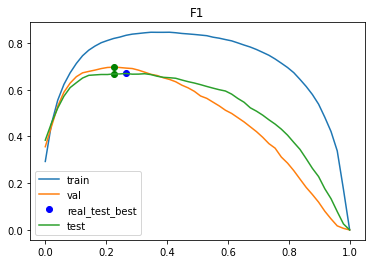

In [89]:
plt.title('F1')
plt.plot(np.linspace(0,1,50), res_train, label='train')
plt.plot(np.linspace(0,1,50), res_val, label='val')
plt.plot(np.linspace(0,1,50)[np.argmax(res_val)], np.max(res_val), 'go')
plt.plot(np.linspace(0,1,50)[np.argmax(res_val)], res_test[np.argmax(res_val)], 'go')
plt.plot(np.linspace(0,1,50)[np.argmax(res_test)], np.max(res_test), 'bo', label='real_test_best')
plt.plot(np.linspace(0,1,50), res_test, label='test')
plt.legend()

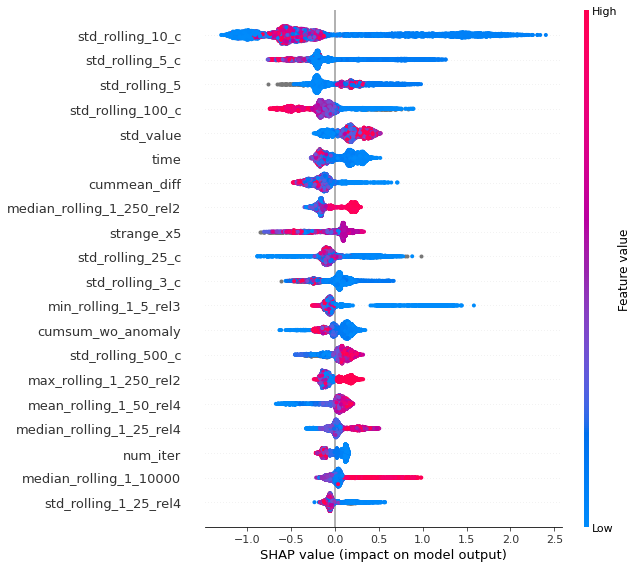

In [90]:
shap_values = cb.get_feature_importance(val_pool, type='ShapValues')[:,:-1]
shap.summary_plot(shap_values, df_val[new_cols])

In [91]:
cb_imps = pd.DataFrame({'cols':new_cols, 
                        'imps': np.mean(np.abs(shap_values),axis=0)}).sort_values(by=['imps'], ascending=False)

In [92]:
cb_imps.head()

,cols,imps
0,std_rolling_10_c,0.786276
1,std_rolling_5_c,0.349395
7,std_rolling_5,0.248107
8,std_rolling_100_c,0.220190
5,std_value,0.214340


In [93]:
new_cols2 = list(cb_imps[cb_imps.imps>0.03]['cols'])
len(new_cols2)

33

In [94]:
new_cols2

['std_rolling_10_c',
 'std_rolling_5_c',
 'std_rolling_5',
 'std_rolling_100_c',
 'std_value',
 'time',
 'cummean_diff',
 'median_rolling_1_250_rel2',
 'strange_x5',
 'std_rolling_25_c',
 'std_rolling_3_c',
 'min_rolling_1_5_rel3',
 'cumsum_wo_anomaly',
 'std_rolling_500_c',
 'max_rolling_1_250_rel2',
 'mean_rolling_1_50_rel4',
 'median_rolling_1_25_rel4',
 'num_iter',
 'median_rolling_1_10000',
 'std_rolling_1_25_rel4',
 'mean_rolling_1_500_rel1',
 'std_rolling_1_25',
 'std_rolling_50_c',
 'std_rolling_1_10',
 'std_rolling_1_10_rel4',
 'min_rolling_1_10000_rel1',
 'max_rolling_1_10000_rel4',
 'std_rolling_1_2_rel4',
 'max_value',
 'std_rolling_1_5_rel1',
 'std_rolling_1_10000_rel1',
 'min_rolling_1_10000',
 'median_rolling_1_10000_rel4']

In [95]:
train_pool = Pool(df_train[new_cols2], df_train['y'])
val_pool = Pool(df_val[new_cols2], df_val['y'])
test_pool = Pool(df_test[new_cols2], df_test['y'])

In [96]:
study_cb = optuna.create_study(direction='maximize')
study_cb.optimize(objective, n_trials=50)

[I 2021-06-13 17:35:42,273] A new study created in memory with name: no-name-ed50021a-cc82-4413-9626-126ee5852be4


TRAIN GINI = 0.9146610888686779
Validate GINI = 0.7822120053772197


[I 2021-06-13 17:35:53,431] Trial 0 finished with value: 0.6724782067247821 and parameters: {'max_depth': 4, 'n_estimators': 715, 'reg_lambda': 47.448161734282536, 'learning_rate': 0.044806704729894474, 'border_count': 159, 'random_strength': 0.00127662446258637, 'bagging_temperature': 0.08087395564052191}. Best is trial 0 with value: 0.6724782067247821.


f1 train =  0.7848
f1 val =  0.6725
f1 test =  0.6629
TRAIN GINI = 0.927525681125793
Validate GINI = 0.795496285558436


[I 2021-06-13 17:36:02,170] Trial 1 finished with value: 0.6707920792079207 and parameters: {'max_depth': 6, 'n_estimators': 636, 'reg_lambda': 77.13071659718503, 'learning_rate': 0.07550933729404499, 'border_count': 36, 'random_strength': 0.03780636647531282, 'bagging_temperature': 0.09655666078893588}. Best is trial 0 with value: 0.6724782067247821.


f1 train =  0.7988
f1 val =  0.6708
f1 test =  0.6646
TRAIN GINI = 0.8278992361317525
Validate GINI = 0.7509771976619286


[I 2021-06-13 17:36:06,844] Trial 2 finished with value: 0.6477064220183486 and parameters: {'max_depth': 2, 'n_estimators': 448, 'reg_lambda': 32.38998618467757, 'learning_rate': 0.011700742857215259, 'border_count': 212, 'random_strength': 1.0697309479059626e-07, 'bagging_temperature': 0.37647572813901253}. Best is trial 0 with value: 0.6724782067247821.


f1 train =  0.7012
f1 val =  0.6477
f1 test =  0.6109
TRAIN GINI = 0.8559409011140326
Validate GINI = 0.7673164784469417


[I 2021-06-13 17:36:20,147] Trial 3 finished with value: 0.6655759162303665 and parameters: {'max_depth': 2, 'n_estimators': 518, 'reg_lambda': 71.67068876297992, 'learning_rate': 0.0225595769338632, 'border_count': 184, 'random_strength': 6.087592438997492, 'bagging_temperature': 0.9936324940275487}. Best is trial 0 with value: 0.6724782067247821.


f1 train =  0.7243
f1 val =  0.6656
f1 test =  0.6332
TRAIN GINI = 0.9396113814143727
Validate GINI = 0.7837312805816292


[I 2021-06-13 17:36:31,960] Trial 4 finished with value: 0.6704132231404958 and parameters: {'max_depth': 4, 'n_estimators': 529, 'reg_lambda': 44.44640195787536, 'learning_rate': 0.07511571917162257, 'border_count': 57, 'random_strength': 0.46123064072476516, 'bagging_temperature': 0.4754388517368867}. Best is trial 0 with value: 0.6724782067247821.


f1 train =  0.8193
f1 val =  0.6704
f1 test =  0.6699
TRAIN GINI = 0.910934546581553
Validate GINI = 0.7799296654466523


[I 2021-06-13 17:36:36,991] Trial 5 finished with value: 0.6738238080202085 and parameters: {'max_depth': 4, 'n_estimators': 425, 'reg_lambda': 42.27649373207816, 'learning_rate': 0.033023414393139466, 'border_count': 154, 'random_strength': 8.865532234561012, 'bagging_temperature': 0.404945472879477}. Best is trial 5 with value: 0.6738238080202085.


f1 train =  0.7775
f1 val =  0.6738
f1 test =  0.6585
TRAIN GINI = 0.8777078663712921
Validate GINI = 0.7608045690665797


[I 2021-06-13 17:36:40,251] Trial 6 finished with value: 0.6624032312352744 and parameters: {'max_depth': 3, 'n_estimators': 226, 'reg_lambda': 75.90908517884803, 'learning_rate': 0.04316424097293756, 'border_count': 37, 'random_strength': 2.9348917021700197e-06, 'bagging_temperature': 0.5809565542926948}. Best is trial 5 with value: 0.6738238080202085.


f1 train =  0.744
f1 val =  0.6624
f1 test =  0.6443
TRAIN GINI = 0.8536483255072065
Validate GINI = 0.7536048670643543


[I 2021-06-13 17:36:56,578] Trial 7 finished with value: 0.6461538461538462 and parameters: {'max_depth': 1, 'n_estimators': 680, 'reg_lambda': 68.20814960137392, 'learning_rate': 0.08269812798771947, 'border_count': 72, 'random_strength': 1.5477213353006454e-09, 'bagging_temperature': 0.9083745623395552}. Best is trial 5 with value: 0.6738238080202085.


f1 train =  0.7309
f1 val =  0.6462
f1 test =  0.6449
TRAIN GINI = 0.9153907611007646
Validate GINI = 0.7581775227776006


[I 2021-06-13 17:37:00,330] Trial 8 finished with value: 0.6455981941309256 and parameters: {'max_depth': 5, 'n_estimators': 373, 'reg_lambda': 63.84859843485344, 'learning_rate': 0.076362840380413, 'border_count': 6, 'random_strength': 0.00031330472879948634, 'bagging_temperature': 0.5495922181716041}. Best is trial 5 with value: 0.6738238080202085.


f1 train =  0.7823
f1 val =  0.6456
f1 test =  0.6243
TRAIN GINI = 0.8686227964866102
Validate GINI = 0.7425932062439458


[I 2021-06-13 17:37:04,527] Trial 9 finished with value: 0.648921832884097 and parameters: {'max_depth': 2, 'n_estimators': 377, 'reg_lambda': 60.836674008587785, 'learning_rate': 0.0376131575074853, 'border_count': 171, 'random_strength': 2.86858841714939e-05, 'bagging_temperature': 0.32622614242565806}. Best is trial 5 with value: 0.6738238080202085.


f1 train =  0.7346
f1 val =  0.6489
f1 test =  0.6423
TRAIN GINI = 0.9461728671619709
Validate GINI = 0.7957775589680294


[I 2021-06-13 17:37:27,450] Trial 10 finished with value: 0.6809927360774818 and parameters: {'max_depth': 7, 'n_estimators': 937, 'reg_lambda': 0.10859897192728596, 'learning_rate': 0.020658514489320254, 'border_count': 249, 'random_strength': 3.014588889569341, 'bagging_temperature': 0.7662912644436606}. Best is trial 10 with value: 0.6809927360774818.


f1 train =  0.8218
f1 val =  0.681
f1 test =  0.6416
TRAIN GINI = 0.9568200359383305
Validate GINI = 0.7983227281501843


[I 2021-06-13 17:37:57,321] Trial 11 finished with value: 0.6863865546218488 and parameters: {'max_depth': 7, 'n_estimators': 863, 'reg_lambda': 3.1236833703300806, 'learning_rate': 0.020754282113250463, 'border_count': 118, 'random_strength': 2.428868705272918, 'bagging_temperature': 0.7647744211560183}. Best is trial 11 with value: 0.6863865546218488.


f1 train =  0.8414
f1 val =  0.6864
f1 test =  0.6591
TRAIN GINI = 0.9596431985975957
Validate GINI = 0.7957385520663003


[I 2021-06-13 17:38:30,633] Trial 12 finished with value: 0.685064935064935 and parameters: {'max_depth': 7, 'n_estimators': 983, 'reg_lambda': 1.5890933332114356, 'learning_rate': 0.01746654734141179, 'border_count': 109, 'random_strength': 0.02639778705495252, 'bagging_temperature': 0.7830754439786887}. Best is trial 11 with value: 0.6863865546218488.


f1 train =  0.8473
f1 val =  0.6851
f1 test =  0.6562
TRAIN GINI = 0.9595782244011768
Validate GINI = 0.8055220562843421


[I 2021-06-13 17:39:23,255] Trial 13 finished with value: 0.685890834191555 and parameters: {'max_depth': 7, 'n_estimators': 997, 'reg_lambda': 6.146157006767755, 'learning_rate': 0.01131653452177303, 'border_count': 113, 'random_strength': 0.026309858210787816, 'bagging_temperature': 0.7742783686275759}. Best is trial 11 with value: 0.6863865546218488.


f1 train =  0.8493
f1 val =  0.6859
f1 test =  0.6603
TRAIN GINI = 0.9269901940401568
Validate GINI = 0.7963641579662375


[I 2021-06-13 17:39:53,321] Trial 14 finished with value: 0.6786266625425301 and parameters: {'max_depth': 6, 'n_estimators': 822, 'reg_lambda': 23.151316210662365, 'learning_rate': 0.010408566312171191, 'border_count': 91, 'random_strength': 0.05988115932596586, 'bagging_temperature': 0.7062932148289316}. Best is trial 11 with value: 0.6863865546218488.


f1 train =  0.7993
f1 val =  0.6786
f1 test =  0.6533
TRAIN GINI = 0.9236237737202211
Validate GINI = 0.7975095651029549


[I 2021-06-13 17:40:25,773] Trial 15 finished with value: 0.6814159292035397 and parameters: {'max_depth': 6, 'n_estimators': 869, 'reg_lambda': 97.81613571663914, 'learning_rate': 0.013032210980443867, 'border_count': 128, 'random_strength': 0.004500008759367774, 'bagging_temperature': 0.9048545318337811}. Best is trial 11 with value: 0.6863865546218488.


f1 train =  0.7942
f1 val =  0.6814
f1 test =  0.6521
TRAIN GINI = 0.9591729477748303
Validate GINI = 0.8122749859456762


[I 2021-06-13 17:41:08,087] Trial 16 finished with value: 0.6923871856699966 and parameters: {'max_depth': 7, 'n_estimators': 793, 'reg_lambda': 13.515531553454633, 'learning_rate': 0.015603773242326145, 'border_count': 119, 'random_strength': 0.39111373967466606, 'bagging_temperature': 0.6755405337478066}. Best is trial 16 with value: 0.6923871856699966.


f1 train =  0.8491
f1 val =  0.6924
f1 test =  0.6655
TRAIN GINI = 0.9308176562896213
Validate GINI = 0.7903217022562068


[I 2021-06-13 17:41:31,520] Trial 17 finished with value: 0.6770262035344302 and parameters: {'max_depth': 5, 'n_estimators': 789, 'reg_lambda': 16.62503523623333, 'learning_rate': 0.016315295181826825, 'border_count': 135, 'random_strength': 0.5036010941572612, 'bagging_temperature': 0.6196587170518806}. Best is trial 16 with value: 0.6923871856699966.


f1 train =  0.804
f1 val =  0.677
f1 test =  0.6558
TRAIN GINI = 0.9626006489825811
Validate GINI = 0.8070360973358037


[I 2021-06-13 17:42:01,766] Trial 18 finished with value: 0.6875808538163002 and parameters: {'max_depth': 7, 'n_estimators': 872, 'reg_lambda': 13.90135016006116, 'learning_rate': 0.02637193032840905, 'border_count': 85, 'random_strength': 0.6511167515979958, 'bagging_temperature': 0.24644336431204472}. Best is trial 16 with value: 0.6923871856699966.


f1 train =  0.8523
f1 val =  0.6876
f1 test =  0.6676
TRAIN GINI = 0.9321814074444581
Validate GINI = 0.7859344851045353


[I 2021-06-13 17:42:17,952] Trial 19 finished with value: 0.6722576316672257 and parameters: {'max_depth': 5, 'n_estimators': 758, 'reg_lambda': 15.752743723684633, 'learning_rate': 0.027364967650400307, 'border_count': 76, 'random_strength': 2.573621176238963e-05, 'bagging_temperature': 0.1956739362989442}. Best is trial 16 with value: 0.6923871856699966.


f1 train =  0.8072
f1 val =  0.6723
f1 test =  0.6633
TRAIN GINI = 0.7484099346564117
Validate GINI = 0.594213943010792


[I 2021-06-13 17:42:21,975] Trial 20 finished with value: 0.542020774315392 and parameters: {'max_depth': 6, 'n_estimators': 626, 'reg_lambda': 29.989339053967694, 'learning_rate': 0.05381583986699457, 'border_count': 2, 'random_strength': 0.2705858194504417, 'bagging_temperature': 0.22655978877833716}. Best is trial 16 with value: 0.6923871856699966.


f1 train =  0.6339
f1 val =  0.542
f1 test =  0.5186
TRAIN GINI = 0.9441466668672998
Validate GINI = 0.8032813403319774


[I 2021-06-13 17:42:45,250] Trial 21 finished with value: 0.6845273931366648 and parameters: {'max_depth': 7, 'n_estimators': 897, 'reg_lambda': 8.51036643370492, 'learning_rate': 0.025875454364275803, 'border_count': 103, 'random_strength': 9.857798926530114, 'bagging_temperature': 0.685668706742021}. Best is trial 16 with value: 0.6923871856699966.


f1 train =  0.8218
f1 val =  0.6845
f1 test =  0.6563
TRAIN GINI = 0.9528943597150086
Validate GINI = 0.8088593272792464


[I 2021-06-13 17:43:24,581] Trial 22 finished with value: 0.6895119418483905 and parameters: {'max_depth': 7, 'n_estimators': 833, 'reg_lambda': 11.774939536357412, 'learning_rate': 0.015582167769822266, 'border_count': 135, 'random_strength': 0.7178940743617738, 'bagging_temperature': 0.8717296307480238}. Best is trial 16 with value: 0.6923871856699966.


f1 train =  0.8356
f1 val =  0.6895
f1 test =  0.6623
TRAIN GINI = 0.949967589388627
Validate GINI = 0.79771768499397


[I 2021-06-13 17:44:00,980] Trial 23 finished with value: 0.6829951014695592 and parameters: {'max_depth': 6, 'n_estimators': 961, 'reg_lambda': 16.53715970400197, 'learning_rate': 0.015334941909597881, 'border_count': 141, 'random_strength': 0.0033932502890539145, 'bagging_temperature': 0.8951950891378923}. Best is trial 16 with value: 0.6923871856699966.


f1 train =  0.8323
f1 val =  0.683
f1 test =  0.6612
TRAIN GINI = 0.9483548568205724
Validate GINI = 0.8078025268745714


[I 2021-06-13 17:44:43,630] Trial 24 finished with value: 0.685362095531587 and parameters: {'max_depth': 7, 'n_estimators': 807, 'reg_lambda': 31.91433227175965, 'learning_rate': 0.013820323941008877, 'border_count': 80, 'random_strength': 0.4835425590179012, 'bagging_temperature': 0.46768708452480695}. Best is trial 16 with value: 0.6923871856699966.


f1 train =  0.8312
f1 val =  0.6854
f1 test =  0.6609
TRAIN GINI = 0.9490373327130037
Validate GINI = 0.7962482588652531


[I 2021-06-13 17:45:12,251] Trial 25 finished with value: 0.6798096532970768 and parameters: {'max_depth': 6, 'n_estimators': 745, 'reg_lambda': 11.798975044777503, 'learning_rate': 0.017684407516586172, 'border_count': 208, 'random_strength': 0.15729049005856852, 'bagging_temperature': 0.6608825164885815}. Best is trial 16 with value: 0.6923871856699966.


f1 train =  0.8299
f1 val =  0.6798
f1 test =  0.6629
TRAIN GINI = 0.9291103055432155
Validate GINI = 0.7939049784396517


[I 2021-06-13 17:45:28,652] Trial 26 finished with value: 0.6754498714652957 and parameters: {'max_depth': 5, 'n_estimators': 625, 'reg_lambda': 23.08884540009613, 'learning_rate': 0.02671173797797003, 'border_count': 56, 'random_strength': 1.778024769198578, 'bagging_temperature': 0.005205721817340414}. Best is trial 16 with value: 0.6923871856699966.


f1 train =  0.8033
f1 val =  0.6754
f1 test =  0.6636
TRAIN GINI = 0.9605440672631698
Validate GINI = 0.8121077422967289


[I 2021-06-13 17:46:11,619] Trial 27 finished with value: 0.6905142127115937 and parameters: {'max_depth': 7, 'n_estimators': 914, 'reg_lambda': 23.84398086084996, 'learning_rate': 0.02007151727660242, 'border_count': 185, 'random_strength': 0.009426587505354113, 'bagging_temperature': 0.8598945921796628}. Best is trial 16 with value: 0.6923871856699966.


f1 train =  0.8502
f1 val =  0.6905
f1 test =  0.6672
TRAIN GINI = 0.9477018725458579
Validate GINI = 0.7969371730913193


[I 2021-06-13 17:46:45,676] Trial 28 finished with value: 0.6817602040816326 and parameters: {'max_depth': 6, 'n_estimators': 921, 'reg_lambda': 35.772726831839435, 'learning_rate': 0.01917402148725843, 'border_count': 196, 'random_strength': 0.00831553355934017, 'bagging_temperature': 0.9888052677080642}. Best is trial 16 with value: 0.6923871856699966.


f1 train =  0.8287
f1 val =  0.6818
f1 test =  0.6653
TRAIN GINI = 0.932326470367558
Validate GINI = 0.8048254154515435


[I 2021-06-13 17:47:23,163] Trial 29 finished with value: 0.6848042468480424 and parameters: {'max_depth': 7, 'n_estimators': 677, 'reg_lambda': 54.10804153815468, 'learning_rate': 0.01339048758709982, 'border_count': 237, 'random_strength': 0.00039073775329603937, 'bagging_temperature': 0.8864890146202948}. Best is trial 16 with value: 0.6923871856699966.


f1 train =  0.8059
f1 val =  0.6848
f1 test =  0.6514
TRAIN GINI = 0.9196983290905081
Validate GINI = 0.7894488449408361


[I 2021-06-13 17:47:44,966] Trial 30 finished with value: 0.6758136566687938 and parameters: {'max_depth': 5, 'n_estimators': 722, 'reg_lambda': 24.711111564892157, 'learning_rate': 0.014755216386669781, 'border_count': 161, 'random_strength': 0.0008789177415764702, 'bagging_temperature': 0.8342955975583661}. Best is trial 16 with value: 0.6923871856699966.


f1 train =  0.789
f1 val =  0.6758
f1 test =  0.6553
TRAIN GINI = 0.9578856225109134
Validate GINI = 0.8039452053975085


[I 2021-06-13 17:48:16,104] Trial 31 finished with value: 0.6906059634498236 and parameters: {'max_depth': 7, 'n_estimators': 846, 'reg_lambda': 11.157679859443972, 'learning_rate': 0.023153581079335624, 'border_count': 147, 'random_strength': 0.08309107525587003, 'bagging_temperature': 0.838711055786046}. Best is trial 16 with value: 0.6923871856699966.


f1 train =  0.8448
f1 val =  0.6906
f1 test =  0.6634
TRAIN GINI = 0.9551274340480671
Validate GINI = 0.8014447757607874


[I 2021-06-13 17:48:48,775] Trial 32 finished with value: 0.6822699583199744 and parameters: {'max_depth': 7, 'n_estimators': 827, 'reg_lambda': 20.134306401523627, 'learning_rate': 0.023047871517433594, 'border_count': 150, 'random_strength': 0.05442985049646251, 'bagging_temperature': 0.9645551805412076}. Best is trial 16 with value: 0.6923871856699966.


f1 train =  0.8402
f1 val =  0.6823
f1 test =  0.6552
TRAIN GINI = 0.9619895709619302
Validate GINI = 0.7926212401178885


[I 2021-06-13 17:49:14,202] Trial 33 finished with value: 0.6854219948849104 and parameters: {'max_depth': 6, 'n_estimators': 987, 'reg_lambda': 8.115986982027374, 'learning_rate': 0.03059487451493928, 'border_count': 170, 'random_strength': 0.0076541710503673895, 'bagging_temperature': 0.8368587096203892}. Best is trial 16 with value: 0.6923871856699966.


f1 train =  0.8526
f1 val =  0.6854
f1 test =  0.6602
TRAIN GINI = 0.9506854381575249
Validate GINI = 0.7996185548728032


[I 2021-06-13 17:49:39,856] Trial 34 finished with value: 0.6868429436126154 and parameters: {'max_depth': 7, 'n_estimators': 917, 'reg_lambda': 0.5487207368861267, 'learning_rate': 0.019210010601705074, 'border_count': 228, 'random_strength': 0.11664784343017771, 'bagging_temperature': 0.8337453165000531}. Best is trial 16 with value: 0.6923871856699966.


f1 train =  0.8292
f1 val =  0.6868
f1 test =  0.6526
TRAIN GINI = 0.9412038312579467
Validate GINI = 0.8048120808237957


[I 2021-06-13 17:50:22,579] Trial 35 finished with value: 0.6845176793683488 and parameters: {'max_depth': 7, 'n_estimators': 782, 'reg_lambda': 27.58819522596054, 'learning_rate': 0.011594946885642398, 'border_count': 186, 'random_strength': 0.011595100045291497, 'bagging_temperature': 0.7242924319075845}. Best is trial 16 with value: 0.6923871856699966.


f1 train =  0.8192
f1 val =  0.6845
f1 test =  0.6561
TRAIN GINI = 0.9486983832773179
Validate GINI = 0.8039884494706713


[I 2021-06-13 17:50:48,699] Trial 36 finished with value: 0.6857490864799025 and parameters: {'max_depth': 6, 'n_estimators': 688, 'reg_lambda': 39.082567126994455, 'learning_rate': 0.022928756270530825, 'border_count': 139, 'random_strength': 0.001877268407986588, 'bagging_temperature': 0.6371327802735467}. Best is trial 16 with value: 0.6923871856699966.


f1 train =  0.8304
f1 val =  0.6857
f1 test =  0.6637
TRAIN GINI = 0.9504151988888434
Validate GINI = 0.7975614081416751


[I 2021-06-13 17:51:20,724] Trial 37 finished with value: 0.6846499678869621 and parameters: {'max_depth': 6, 'n_estimators': 842, 'reg_lambda': 9.562915766763357, 'learning_rate': 0.016898250205135166, 'border_count': 175, 'random_strength': 1.2859359909384938, 'bagging_temperature': 0.9582962260031979}. Best is trial 16 with value: 0.6923871856699966.


f1 train =  0.8325
f1 val =  0.6846
f1 test =  0.6592
TRAIN GINI = 0.8963177780255829
Validate GINI = 0.7765778135971082


[I 2021-06-13 17:51:36,410] Trial 38 finished with value: 0.6701742847747453 and parameters: {'max_depth': 3, 'n_estimators': 596, 'reg_lambda': 88.34847595716963, 'learning_rate': 0.031081784099465107, 'border_count': 152, 'random_strength': 9.219374721059099, 'bagging_temperature': 0.8337184067519587}. Best is trial 16 with value: 0.6923871856699966.


f1 train =  0.764
f1 val =  0.6702
f1 test =  0.6562
TRAIN GINI = 0.9439969476937484
Validate GINI = 0.8037617607989609


[I 2021-06-13 17:52:14,671] Trial 39 finished with value: 0.6851612903225807 and parameters: {'max_depth': 7, 'n_estimators': 716, 'reg_lambda': 20.226462529398184, 'learning_rate': 0.012418109847804384, 'border_count': 123, 'random_strength': 0.0943657209737781, 'bagging_temperature': 0.5457479900664924}. Best is trial 16 with value: 0.6923871856699966.


f1 train =  0.8244
f1 val =  0.6852
f1 test =  0.6537
TRAIN GINI = 0.8905607997185723
Validate GINI = 0.7715844316850198


[I 2021-06-13 17:52:30,604] Trial 40 finished with value: 0.6706507304116865 and parameters: {'max_depth': 4, 'n_estimators': 565, 'reg_lambda': 47.60939253306843, 'learning_rate': 0.015044632647216132, 'border_count': 196, 'random_strength': 2.90575214309947e-07, 'bagging_temperature': 0.957373512060549}. Best is trial 16 with value: 0.6923871856699966.


f1 train =  0.7543
f1 val =  0.6707
f1 test =  0.6436
TRAIN GINI = 0.9589179632114895
Validate GINI = 0.8093201819840208


[I 2021-06-13 17:53:00,775] Trial 41 finished with value: 0.6874562018220043 and parameters: {'max_depth': 7, 'n_estimators': 879, 'reg_lambda': 13.376167374192265, 'learning_rate': 0.023722515474380406, 'border_count': 95, 'random_strength': 0.7042678323785301, 'bagging_temperature': 0.2884179084980759}. Best is trial 16 with value: 0.6923871856699966.


f1 train =  0.8472
f1 val =  0.6875
f1 test =  0.665
TRAIN GINI = 0.9508010765031638
Validate GINI = 0.7996859757476769


[I 2021-06-13 17:53:19,005] Trial 42 finished with value: 0.6820248560169748 and parameters: {'max_depth': 7, 'n_estimators': 947, 'reg_lambda': 4.667429453612426, 'learning_rate': 0.0350866157210131, 'border_count': 49, 'random_strength': 3.9737355357959605, 'bagging_temperature': 0.1377901497699233}. Best is trial 16 with value: 0.6923871856699966.


f1 train =  0.8304
f1 val =  0.682
f1 test =  0.6619
TRAIN GINI = 0.9628427069658076
Validate GINI = 0.8099854178991333


[I 2021-06-13 17:53:57,430] Trial 43 finished with value: 0.6907284768211921 and parameters: {'max_depth': 7, 'n_estimators': 902, 'reg_lambda': 12.638432955146495, 'learning_rate': 0.019764351470946944, 'border_count': 128, 'random_strength': 0.21124838109896985, 'bagging_temperature': 0.43456453576063786}. Best is trial 16 with value: 0.6923871856699966.


f1 train =  0.8549
f1 val =  0.6907
f1 test =  0.664
TRAIN GINI = 0.8925396452148027
Validate GINI = 0.7838627575187673


[I 2021-06-13 17:54:00,910] Trial 44 finished with value: 0.6718591263122249 and parameters: {'max_depth': 6, 'n_estimators': 190, 'reg_lambda': 19.380058789110777, 'learning_rate': 0.020503899225469614, 'border_count': 159, 'random_strength': 0.025617915880750682, 'bagging_temperature': 0.3917404402120687}. Best is trial 16 with value: 0.6923871856699966.


f1 train =  0.7548
f1 val =  0.6719
f1 test =  0.6404
TRAIN GINI = 0.962146957102848
Validate GINI = 0.8055471054448773


[I 2021-06-13 17:54:40,313] Trial 45 finished with value: 0.6900467601870408 and parameters: {'max_depth': 7, 'n_estimators': 913, 'reg_lambda': 10.270240427053968, 'learning_rate': 0.01852452401038986, 'border_count': 130, 'random_strength': 0.1959830645909242, 'bagging_temperature': 0.45430714062006283}. Best is trial 16 with value: 0.6923871856699966.


f1 train =  0.8531
f1 val =  0.69
f1 test =  0.6628
TRAIN GINI = 0.9634141093445212
Validate GINI = 0.8114422571362381


[I 2021-06-13 17:55:24,428] Trial 46 finished with value: 0.6921241050119331 and parameters: {'max_depth': 7, 'n_estimators': 992, 'reg_lambda': 26.402980961606524, 'learning_rate': 0.01961342366844924, 'border_count': 100, 'random_strength': 0.20429993760002527, 'bagging_temperature': 0.44871372772306983}. Best is trial 16 with value: 0.6923871856699966.


f1 train =  0.8574
f1 val =  0.6921
f1 test =  0.6716
TRAIN GINI = 0.8312548690651709
Validate GINI = 0.7509295917946428


[I 2021-06-13 17:55:47,431] Trial 47 finished with value: 0.6563833278634722 and parameters: {'max_depth': 1, 'n_estimators': 996, 'reg_lambda': 36.77198576032343, 'learning_rate': 0.021606018360460912, 'border_count': 104, 'random_strength': 0.0336314210268204, 'bagging_temperature': 0.42781092135362964}. Best is trial 16 with value: 0.6923871856699966.


f1 train =  0.7077
f1 val =  0.6564
f1 test =  0.6336
TRAIN GINI = 0.9324155242047287
Validate GINI = 0.7948435119122468


[I 2021-06-13 17:56:22,507] Trial 48 finished with value: 0.6767427513880321 and parameters: {'max_depth': 6, 'n_estimators': 960, 'reg_lambda': 25.52052386650717, 'learning_rate': 0.010159132294058572, 'border_count': 66, 'random_strength': 0.019077149323397873, 'bagging_temperature': 0.49639589905582454}. Best is trial 16 with value: 0.6923871856699966.


f1 train =  0.8057
f1 val =  0.6767
f1 test =  0.6555
TRAIN GINI = 0.9592075161682354
Validate GINI = 0.7949156684493113


[I 2021-06-13 17:56:29,221] Trial 49 finished with value: 0.6773839970770917 and parameters: {'max_depth': 7, 'n_estimators': 460, 'reg_lambda': 43.94320045390057, 'learning_rate': 0.029027731309586913, 'border_count': 121, 'random_strength': 9.641286645087817e-05, 'bagging_temperature': 0.34946728946315664}. Best is trial 16 with value: 0.6923871856699966.


f1 train =  0.8481
f1 val =  0.6774
f1 test =  0.6542


In [97]:
best_params =   {'max_depth': 7, 'n_estimators': 793, 'reg_lambda': 13.515531553454633,
                 'learning_rate': 0.015603773242326145, 'border_count': 119, 
                 'random_strength': 0.39111373967466606, 'bagging_temperature': 0.6755405337478066,
                       'task_type': 'GPU',
        "loss_function":'Logloss',
        'random_state':123}

In [98]:
cb = CatBoostClassifier(**best_params)
cb.fit(train_pool, eval_set=val_pool, verbose=100, early_stopping_rounds=50)

0:	learn: 0.6758860	test: 0.6781258	best: 0.6781258 (0)	total: 55.7ms	remaining: 44.1s
100:	learn: 0.2537114	test: 0.3703843	best: 0.3703843 (100)	total: 5.06s	remaining: 34.6s
200:	learn: 0.2140018	test: 0.3486567	best: 0.3486179 (199)	total: 9.97s	remaining: 29.4s
300:	learn: 0.1937332	test: 0.3375033	best: 0.3375033 (300)	total: 14.8s	remaining: 24.3s
400:	learn: 0.1789323	test: 0.3293049	best: 0.3292373 (399)	total: 19.7s	remaining: 19.3s
500:	learn: 0.1676318	test: 0.3229610	best: 0.3229360 (499)	total: 24.6s	remaining: 14.3s
600:	learn: 0.1581177	test: 0.3190953	best: 0.3190953 (600)	total: 29.5s	remaining: 9.41s
700:	learn: 0.1500363	test: 0.3165801	best: 0.3164633 (697)	total: 34.4s	remaining: 4.51s
792:	learn: 0.1436798	test: 0.3148167	best: 0.3147458 (788)	total: 38.9s	remaining: 0us
bestTest = 0.3147457885
bestIteration = 788
Shrink model to first 789 iterations.


In [99]:
res_val = []
res_train = []
res_test = []
for i in np.linspace(0,1,50):
    res_val.append(f1_score(df_val['y'], cb.predict_proba(val_pool)[:,1]>i))
    res_train.append(f1_score(df_train['y'], cb.predict_proba(train_pool)[:,1]>i))
    res_test.append(f1_score(df_test['y'], cb.predict_proba(test_pool)[:,1]>i))
print(np.max(res_val), res_test[np.argmax(res_val)], np.linspace(0,1,50)[np.argmax(res_val)])

0.6923871856699966 0.6654622101776573 0.26530612244897955


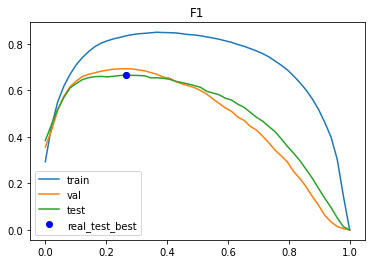

In [100]:
plt.title('F1')
plt.plot(np.linspace(0,1,50), res_train, label='train')
plt.plot(np.linspace(0,1,50), res_val, label='val')
plt.plot(np.linspace(0,1,50), res_test, label='test')
plt.plot(np.linspace(0,1,50)[np.argmax(res_val)], res_test[np.argmax(res_val)], 'go')
plt.plot(np.linspace(0,1,50)[np.argmax(res_test)], np.max(res_test), 'bo', label='real_test_best')
plt.legend()

In [101]:
len(new_cols2)

33

In [102]:
train_val_pool = Pool(pd.concat([df_train[new_cols2], df_val[new_cols2]]), pd.concat([df_train['y'], df_val['y']]))

In [103]:
test_pool = Pool(df_test[new_cols2], df_test['y'])
cb.fit(train_val_pool, verbose=0)

In [104]:
f1_score(df_test['y'], cb.predict_proba(test_pool)[:,1]>0.265)

0.6776297136376525

In [105]:
cb.save_model('1406_best_model')

In [106]:
all_pool = Pool(pd.concat([df_train[new_cols2], df_val[new_cols2], df_test[new_cols2]]),
                pd.concat([df_train['y'], df_val['y'], df_test['y']]))

In [107]:
cb.fit(all_pool, verbose=0)

In [108]:
cb.save_model('1406_all_data_studied')

## Scoring

In [109]:
df = pd.read_csv('train.csv')
df.sort_values(by=['id', 'time'], inplace=True)
df_test_tmp = df[df.id>=225].copy()
df_test = df_test_tmp.drop(['y'], axis=1)

In [111]:
new_cols2 = ['std_rolling_10_c',
 'std_rolling_5_c',
 'std_rolling_5',
 'std_rolling_100_c',
 'std_value',
 'time',
 'cummean_diff',
 'median_rolling_1_250_rel2',
 'strange_x5',
 'std_rolling_25_c',
 'std_rolling_3_c',
 'min_rolling_1_5_rel3',
 'cumsum_wo_anomaly',
 'std_rolling_500_c',
 'max_rolling_1_250_rel2',
 'mean_rolling_1_50_rel4',
 'median_rolling_1_25_rel4',
 'num_iter',
 'median_rolling_1_10000',
 'std_rolling_1_25_rel4',
 'mean_rolling_1_500_rel1',
 'std_rolling_1_25',
 'std_rolling_50_c',
 'std_rolling_1_10',
 'std_rolling_1_10_rel4',
 'min_rolling_1_10000_rel1',
 'max_rolling_1_10000_rel4',
 'std_rolling_1_2_rel4',
 'max_value',
 'std_rolling_1_5_rel1',
 'std_rolling_1_10000_rel1',
 'min_rolling_1_10000',
 'median_rolling_1_10000_rel4']
tresh = 0.265

In [116]:
def scoring(test_df, path_to_model, new_cols2, tresh, target_col='pred2_bin'):
  test_df = anomaly_detected(test_df)
  test_df = first_prepr(test_df, delete_anomaly = False)
  df_test = test_df[['id', 'time', 'x']].copy()

  test_df = feature_generate(test_df)
  pred_df = test_df[['id', 'time', 'x', 'anomaly__1', 'less066','mean_rolling_new2_1']].copy()

  pred_df = pred_df[(pred_df.anomaly__1==1) |(pred_df.less066==1)|(pred_df.mean_rolling_new2_1==1)]
  pred_df['pred'] = 0
  test_df = test_df[(test_df.anomaly__1==0) &(test_df.less066==0)&(test_df.mean_rolling_new2_1==0)]
  

  cb = CatBoostClassifier()
  cb.load_model(path_to_model)
  test_df['pred2'] = cb.predict_proba(Pool(test_df[new_cols2]))[:,1]
  test_df[target_col] = (test_df['pred2'] > tresh).astype(int)

  df_test = df_test.merge(pred_df[['id', 'time', 'x', 'pred']], 
                          on =['id', 'time', 'x'], how='left')
  df_test = df_test.merge(test_df[['id', 'time', 'x', 'pred2', 'pred2_bin']], 
                          on =['id', 'time', 'x'], how='left')
  df_test.loc[(df_test.pred2_bin.isnull()), target_col] = df_test.loc[(df_test[target_col].isnull()), 'pred']
  return df_test

In [118]:
res = scoring(df_test, '1406_best_model', new_cols2, tresh)

In [119]:
print(res.shape)
res2 = res.merge(df_test_tmp, on =['id', 'time', 'x'])
print(res2.shape)

(8309, 6)
(8309, 7)


In [120]:
f1_score(res2['pred2_bin'], res2['y'], average='micro')

0.8668913226621735

In [121]:
f1_score(res2['pred2_bin'], res2['y'])

0.6716152019002376